# Ultrafast image categorization *in vivo* and *in sillico*

In this notebook, we train a network to categorize images which contain or not a given class, such as *animals* or *artifacts*. We will use the [Pytorch](https://pytorch.org/) library to run the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. 

I uses transfer learning to train the DCNN, starting from a VGG16 network, taken from the `torchvision.models` library, pre-trained on the [Imagenet](http://image-net.org/) dataset which allows to perform label detection on naturals images for $K = 1000$ labels. Then re-train the whole network to perfom the same task but in a sub-set of $K = 1$ synset from the ImageNet dataset. The dataset I used here to train the networks is not multilabel (as we have the information about the occurence of only one synset on the scene), in order to train networks on independant task I choose to limit the output of the DCNN to $K = 1$ synset. 

We are going to adopt differents strategies of transfer learning:

* VGG General : Substitute the last layer of the Pytorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Gray : Same architecture as the VGG General network but trained with images in grayscale.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

The first part consist of the training of the network and the last part of this notebook is dedicated to the test of the robustness of the resulted networks while appliying various geometric tranformations to the input. Finally I analyse the similarities in the performances of the networks compared with physiological data. 

This notebook was done by  [Jean-Nicolas Jérémie](https://github.com/JNJER) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/) at the Neurosciences Institute of Timone (INT). It is curated in the following [github repo](https://github.com/JNJER/2022-09_UltraFastCat).

Let's first install requirements

In [1]:
#%pip install --upgrade -r requirements.txt

In [2]:
%matplotlib inline

## Initialization of the libraries/variables


Our coding strategy is to include all scripts in this notebook. This notebook contains the scripts necessary to set the variables of the definition and the training of the networks and assumes you have generated the dataset based on the [ImageNet database](https://www.image-net.org/) dedicated to our specific ecologic task. 

The set of labels of the ImageNet database is based on a large lexical database of English: [Wordnet](https://wordnet.princeton.edu/) . The nouns, verbs, adjectives, and adverbs in this database are grouped into a graphical set of cognitive synonyms (synset), each expressing a distinct concept. These synsets are linked between them by employing a small number of conceptual relations. I used the hyperonym link, for instance, a German shepherd is kind of a dog and a dog is a kind of an animal thus defining an hyperonym path. So the synset 'animal' is in the hyperonym path of the synset 'German sheperd'. Based on this relation, we selected a specific subset of labels in the ImageNet database to build our datasets.


In [3]:
data_cache = 'cached_data'
%mkdir -p {data_cache}

First of all, a `UltraFastCat/init.py` to define all our usefull variables like the new labels to learn, the number of training images or the root. Also, we importe libraries to train the networks and display the results. Then we define the `transforme`functions for the datasets. To perform image augmentation we apply the Pytorch `AutoAugment` function to the `train` and `val` dataset. I also add a grayscale, shuffle and resize function in order to test different training strategies and test the networks on various conditions.  

TODO: make a task of categorizing an animal in an image where the distractors is not an artifact

In [4]:
# Importing libraries
import torch
import torch.nn.functional as nnf
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
torch.manual_seed(42*42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')

torch.__version__, device

('2.0.0.dev20230227', device(type='cpu'))

In [5]:
import numpy as np
from numpy import random
import argparse
import json
import matplotlib.pyplot as plt
from matplotlib import font_manager
fontsize = 15
font = font_manager.FontProperties(weight='normal', size=fontsize)
import seaborn as sns

# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm', 'y']
fig_width = 15
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))

do_savefig = True
# figpath = '../2022-12-15_Jérémie-etal-Vision_630dcf8012267a5bb40967dd/Figures'
figpath = 'figures'
%mkdir -p {figpath}
opts_savefig = dict(dpi='figure', bbox_inches='tight', pad_inches=0, edgecolor=None)

In [6]:

from nltk.corpus import wordnet as wn
#from numpy import random
import os
import requests
import time

from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())
# datetag = '2022-12-15' # freeze to that date

HOST = os.uname()[1].replace('.local', '')
# HOST = 'obiwan' # freeze to host
# import platform
# print(platform.platform())

# to store results
import pandas as pd

def arg_parse(args=[]):
    DEBUG = 8
    DEBUG = 1
    parser = argparse.ArgumentParser(description='DCNN_transfer_learning/init.py set root')
    parser.add_argument("--root", dest = 'root', help = "Directory containing images to perform the training",
                        default = '../data/', type = str)
    parser.add_argument("--folders", dest = 'folders', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--tasks", dest = 'tasks', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['animal', 'artifact'], type = list)
    parser.add_argument("--goals", dest = 'goals', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['target', 'distractor'], type = list)
    parser.add_argument("--N_images", dest = 'N_images', help ="Set the number of images per classe in the train folder",
                        default = [600//DEBUG, 400//DEBUG, 1000//DEBUG], type = list)
    parser.add_argument("--HOST", dest = 'HOST', help = "Set the name of your machine",
                    default=HOST, type = str)
    parser.add_argument("--datetag", dest = 'datetag', help = "Set the datetag of the result's file",
                    default = datetag, type = str)
    parser.add_argument("--image_size", dest = 'image_size', help = "Set the default image_size of the input",
                    default = 256)
    parser.add_argument("--image_sizes", dest = 'image_sizes', help = "Set the image_sizes of the input for experiment 2 (downscaling)",
                    default = [64, 128, 256, 512], type = list)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = "Set the number of epoch to perform during the traitransportationning phase",
                    default = 25//DEBUG)
    parser.add_argument("--batch_size", dest = 'batch_size', help="Set the batch size", default = 16)
    parser.add_argument("--lr", dest = 'lr', help="Set the learning rate", default = 0.0001*DEBUG)
    parser.add_argument("--momentum", dest = 'momentum', help="Set the momentum", default = 0.9)
    parser.add_argument("--beta2", dest = 'beta2', help="Set the second momentum - use zero for SGD", default = 0.995)
    parser.add_argument("--url_loader", dest = 'url_loader', help = "Set the file containing ImageNet urls",
                        default = '../DataSetMaker/Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_path", dest = 'model_path', help = "Set the path to the pre-trained model",
                        default = f'{data_cache}/{datetag}_re-train_', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = "Modes for the new trained networks",
                        default = ['vgg16_custom', 'vgg16_full','vgg16_gen', 'vgg16_naive'], type = list)
    return parser.parse_args(args = args)

args = arg_parse()
datetag = args.datetag
json_fname = os.path.join(data_cache, datetag + '_config_args.json')
load_parse = False # False to custom the config

if load_parse:
    with open(json_fname, 'rt') as f:
        print(f'file {json_fname} exists: LOADING')
        override = json.load(f)
        args.__dict__.update(override)
else:
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(vars(args), f, indent=4)
    
    


Creating file cached_data/2022-12-15_config_args.json


In [7]:
import nltk
nltk.download('omw-1.4', download_dir=args.root)
nltk.download('wordnet', download_dir=args.root)

[nltk_data] Downloading package omw-1.4 to ../data/...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to ../data/...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
nltk.data.path.append(args.root)

In [9]:
#DCCN training
print(f'On date {args.datetag}, Running benchmark on host {args.HOST} with device {device}')

paths = {}
match = {}

for task in args.tasks :
    paths[task] = {}
    match[task] = []
    for folder in args.folders:
        paths[task][folder] = os.path.join(args.root, task, folder) # data path
    
with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

    
#----------------Get the label for the Imagenet categorization------------------------
for i_img, img_id in enumerate(Imagenet_urls_ILSVRC_2016):
    syn_= wn.synset_from_pos_and_offset('n', int(img_id.replace('n','')))
    sem_ = syn_.hypernym_paths()[0]
    for task in args.tasks :
        for i in np.arange(len(sem_)):
            if sem_[i].lemmas()[0].name() in task :
                match[task].append(i_img)
#------------------------------------------------------------------------------------


class ShufflePatches(object): #https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.ps = patch_size

    def __call__(self, x):
        # divide the batch of images into non-overlapping patches
        u = nnf.unfold(x.unsqueeze(dim=0), kernel_size=self.ps, stride=self.ps, padding=0)
        # permute the patches of each image in the batch
        pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
        # fold the permuted patches back together
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
        return f.squeeze(dim=0)

# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=mean, std=std) # to normalize colors on the ImageNet dataset


# import sklearn.metrics
# from scipy import stats
# from scipy.special import logit, expit

image_datasets = {}
dataloaders = {}
dataset_sizes = {}

# VGG-16 datasets initialisation
def datasets_transforms(paths=paths, image_size=args.image_size, p=0, shuffle=args.image_size , num_workers=0, angle=0, batch_size=args.batch_size, **kwargs):
    data_transforms = {

        'train': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            # transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugmentdistractor
            transforms.RandomRotation(degrees=180, expand=True),
            transforms.ToTensor(),    # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'val': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomRotation(degrees=180, expand=True),
            transforms.ToTensor(),    
            transforms_norm ]),

        'test': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomRotation(degrees=180, expand=True),
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),
            #CleanRotation(angle),
            transforms_norm, 
            # ShufflePatches(patch_size=(shuffle, shuffle)) # our new transform to shuffle patches of images
        ])}
    
    if p != 0 : 
        data_transforms['train'] = transforms.Compose([
                transforms.Resize((int(image_size), int(image_size))),              
                transforms.RandomHorizontalFlip(p=p),
                transforms.RandomVerticalFlip(p=p),
                transforms.RandomGrayscale(p=p),
                transforms.ToTensor(),
                transforms_norm ])
    
    for task in args.tasks:
        image_datasets[task] = {
            folder: datasets.ImageFolder(
                paths[task][folder], 
                transform=data_transforms[folder]
            )
            for folder in args.folders
        }

        dataloaders[task] = {
            folder: torch.utils.data.DataLoader(
                image_datasets[task][folder], batch_size=batch_size,
                shuffle=False if folder == "test" else True, num_workers=num_workers
            )
            for folder in args.folders
        }

        dataset_sizes[task] = {folder: len(image_datasets[task][folder]) for folder in args.folders}

    return dataset_sizes, dataloaders, image_datasets, data_transforms

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size)


for task in args.tasks :
    pprint(f'Pre-selected tasks {task} : ')
    for folder in args.folders : print(f"Loaded {dataset_sizes[task][folder]} images under {folder}")
        

On date 2022-12-15, Running benchmark on host obiwan with device cpu
----------------------------
Pre-selected tasks animal : 
----------------------------
Loaded 1200 images under test
Loaded 1200 images under val
Loaded 2000 images under train
------------------------------
Pre-selected tasks artifact : 
------------------------------
Loaded 1200 images under test
Loaded 800 images under val
Loaded 2000 images under train


In [10]:
args

Namespace(root='../data/', folders=['test', 'val', 'train'], tasks=['animal', 'artifact'], goals=['target', 'distractor'], N_images=[600, 400, 1000], HOST='obiwan', datetag='2022-12-15', image_size=256, image_sizes=[64, 128, 256, 512], num_epochs=25, batch_size=16, lr=0.0001, momentum=0.9, beta2=0.995, url_loader='../DataSetMaker/Imagenet_urls_ILSVRC_2016.json', model_path='cached_data/2022-12-15_re-train_', model_names=['vgg16_custom', 'vgg16_full', 'vgg16_gen', 'vgg16_naive'])



-------------------------------------
Some sample images picked at random :
-------------------------------------


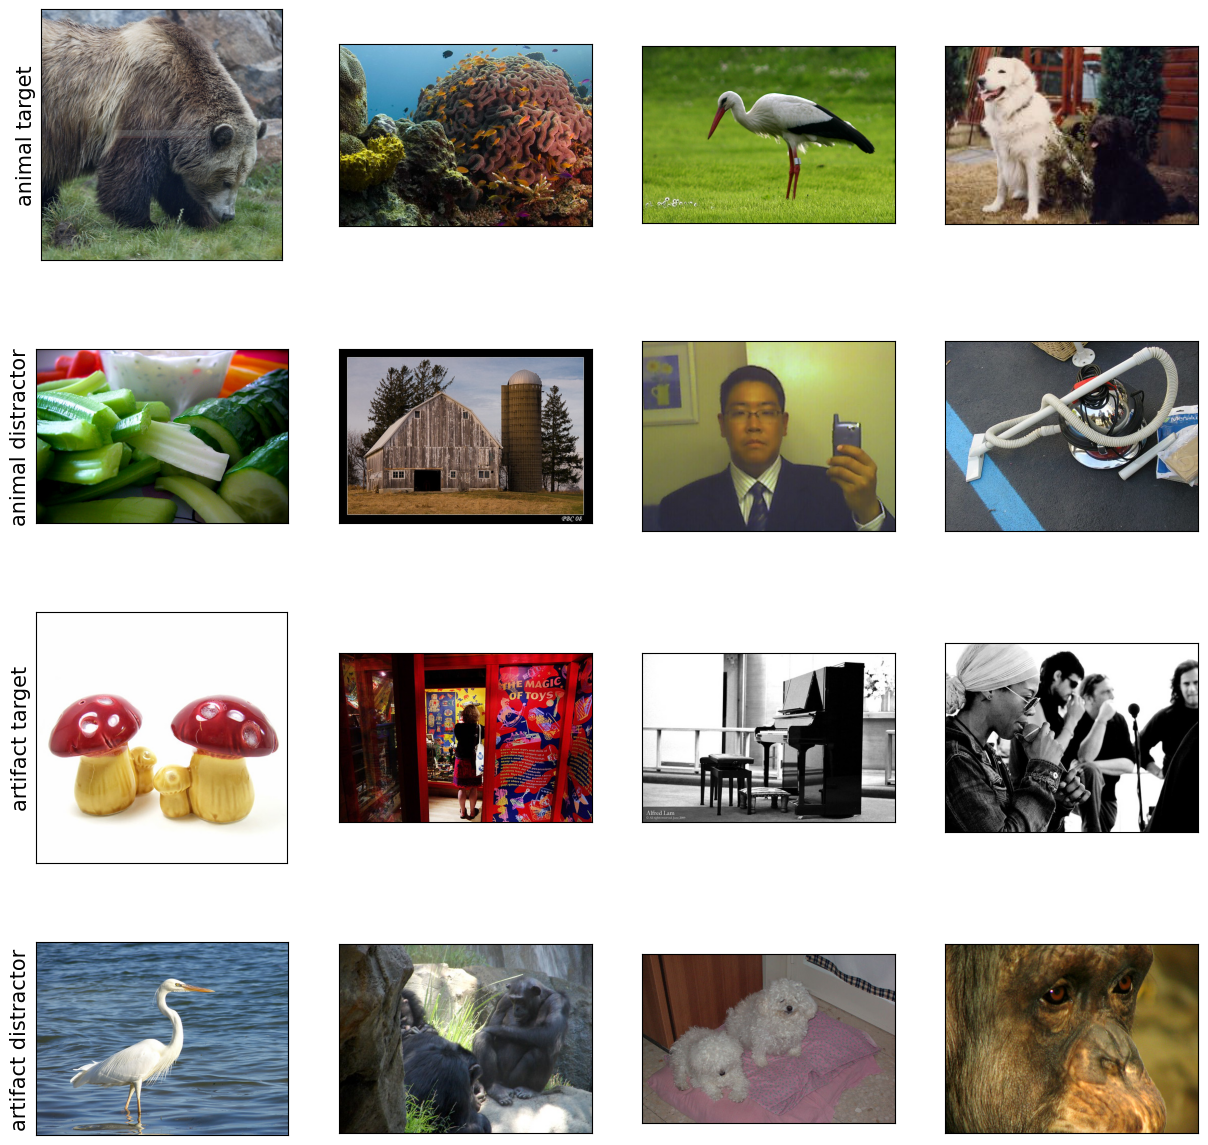

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#----------------------------Display randomly picked images------------------------------------
print('\n')
pprint(f'Some sample images picked at random :')
# import imageio
import imageio.v2 as imageio
N_image_i = 4
image_plot_paths = {}
task_folder = {}
x = 0
folder = 'train'
fig, axs = plt.subplots(len(args.tasks)*len(args.goals), N_image_i, figsize=(fig_width, fig_width))
for task in args.tasks:
    for goal in args.goals:
        task_goal_folder = os.path.join(paths[task][folder], goal)
        image_plot_paths = os.listdir(task_goal_folder)
        for i_image in np.arange(N_image_i):
            ax = axs[x][i_image]
            path = os.path.join(task_goal_folder, random.choice(image_plot_paths))
            ax.imshow(imageio.imread(path))
            ax.set_xticks([])
            ax.set_yticks([])  
            if i_image%5 == 0:
                ax.set_ylabel((task+' '+goal), font=font)
        x +=1
fig.set_facecolor(color='white')
#-------------------------------------------------------------------

# Training process

This part of the notebook focus on the training process of the network. 

The following script is a classic Training script with pyTorch. Since I only have one synset to discriminate in the scene I use `criterion = nn.BCEWithLogitsLoss()` to compute the loss during the training process. For further statistical analyses, we extract factors (like the accuracy and loss) in a `pandas`' `DataFrame` object. 

## Training script

In [12]:
def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, beta2=args.beta2, log_interval=100, **kwargs):
    model.to(device)
    # https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
    # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss
    criterion = nn.BCEWithLogitsLoss() #binary_cross_entropy_with_logits
    if beta2 > 0.: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(momentum, beta2)) 
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables
        
    # model.train()
    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val']) 
    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        num_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.float())            
            loss.backward()
            optimizer.step()
            loss_train += loss.item() * images.size(0)
            
            preds = (outputs > 0).long()
            acc_train += (preds == labels).sum().item() # count correct predictions
            num_train += len(labels)
        avg_loss = loss_train / num_train
        avg_acc = acc_train / num_train
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            num_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images).squeeze(1)

                loss = criterion(outputs, labels.float())
                loss_val += loss.item() * images.size(0)

                preds = (outputs > 0).long()
                acc_val += (preds == labels).sum().item() # count correct predictions
                num_val += len(labels)
            avg_loss_val = loss_val / num_val
            avg_acc_val = acc_val / num_val
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':avg_acc, 'avg_loss_val':avg_loss_val, 'avg_acc_val':avg_acc_val}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    # if device=='cuda': torch.cuda.empty_cache()
    model.cpu()
    return model, df_train


In [13]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT) #pretrained=True) #

In [14]:
for param in model.classifier.parameters():
    param.require_grad = False
    print(param.size(), param.requires_grad)

torch.Size([4096, 25088]) True
torch.Size([4096]) True
torch.Size([4096, 4096]) True
torch.Size([4096]) True
torch.Size([1000, 4096]) True
torch.Size([1000]) True


In [15]:
# Training and saving the networks
models_vgg = {}
opt = {}
all_models = []   
model_filenames = {}

n_output = 1

for task in args.tasks :
    for model in args.model_names:
        model_name = f'{model}_{task}'

        all_models.append(model_name)
        model_filenames[model_name] = args.model_path + model_name + '.pt'
        filename = f'{data_cache}/{datetag}_{args.HOST}_train_{model_name}.json'
        print(filename)
        
        if model=='naive': # in model_name:
            models_vgg[model_name] = torchvision.models.vgg16() # pretrained=False) #
        else:
            models_vgg[model_name] = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT) # pretrained=True) #
            
        if model=='full': # not 'full' in model_name : #  
            for param in models_vgg[model_name].features.parameters():
                param.requires_grad = False 
                
        num_features = models_vgg[model_name].classifier[-1].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, n_output)]) # Add our layer with n_output=1 outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier
        
        if os.path.isfile(filename):
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name]))
        else:
            print("Re-training pretrained model...", model_filenames[model_name])
            print(f"Traning {model_name}, image_size={args.image_size}")
            since = time.time()
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, 
                                                                                                image_size=args.image_size, 
                                                                                                batch_size=args.batch_size, 
                                                                                                p=0.5 if 'custom' in model_name else 0)
            models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                                      dataloaders=dataloaders[task], lr=args.lr, 
                                                                      momentum=args.momentum)
            elapsed_time = time.time() - since
            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
            torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
            df_train.to_json(filename)
            print()
            
updict = {"vgg_16" : torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)}
updict.update(models_vgg)
models_vgg = updict

cached_data/2022-12-15_obiwan_train_vgg16_custom_animal.json
cached_data/2022-12-15_obiwan_train_vgg16_full_animal.json
cached_data/2022-12-15_obiwan_train_vgg16_gen_animal.json
cached_data/2022-12-15_obiwan_train_vgg16_naive_animal.json
cached_data/2022-12-15_obiwan_train_vgg16_custom_artifact.json
cached_data/2022-12-15_obiwan_train_vgg16_full_artifact.json
cached_data/2022-12-15_obiwan_train_vgg16_gen_artifact.json
cached_data/2022-12-15_obiwan_train_vgg16_naive_artifact.json


## Average accuracy and loss

In [16]:
all_models, args.model_names

(['vgg16_custom_animal',
  'vgg16_full_animal',
  'vgg16_gen_animal',
  'vgg16_naive_animal',
  'vgg16_custom_artifact',
  'vgg16_full_artifact',
  'vgg16_gen_artifact',
  'vgg16_naive_artifact'],
 ['vgg16_custom', 'vgg16_full', 'vgg16_gen', 'vgg16_naive'])

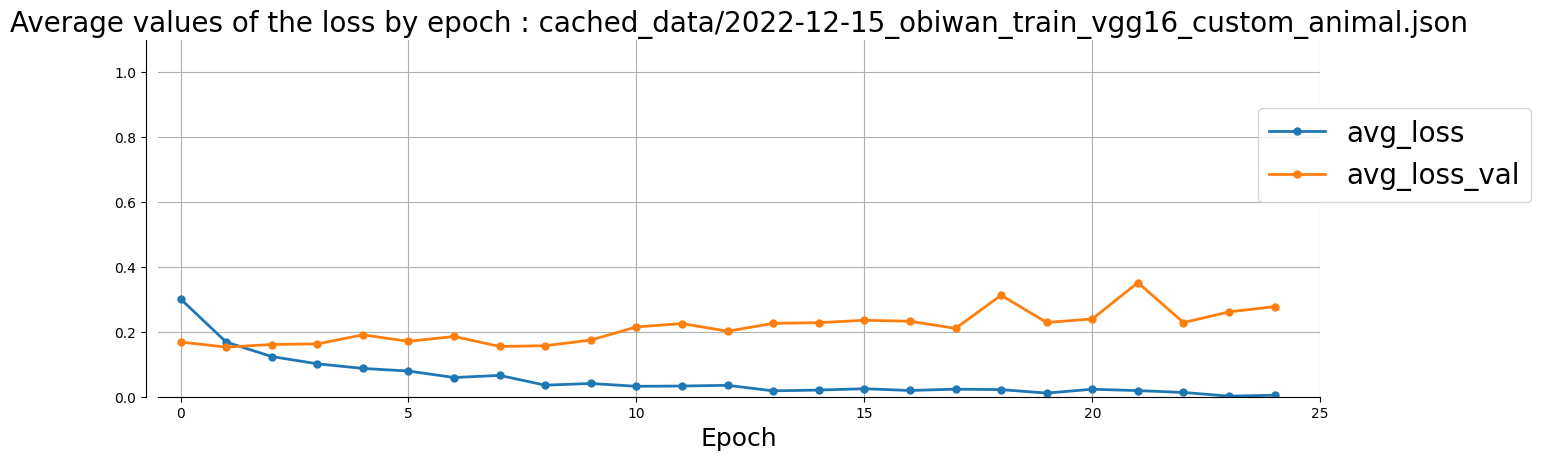

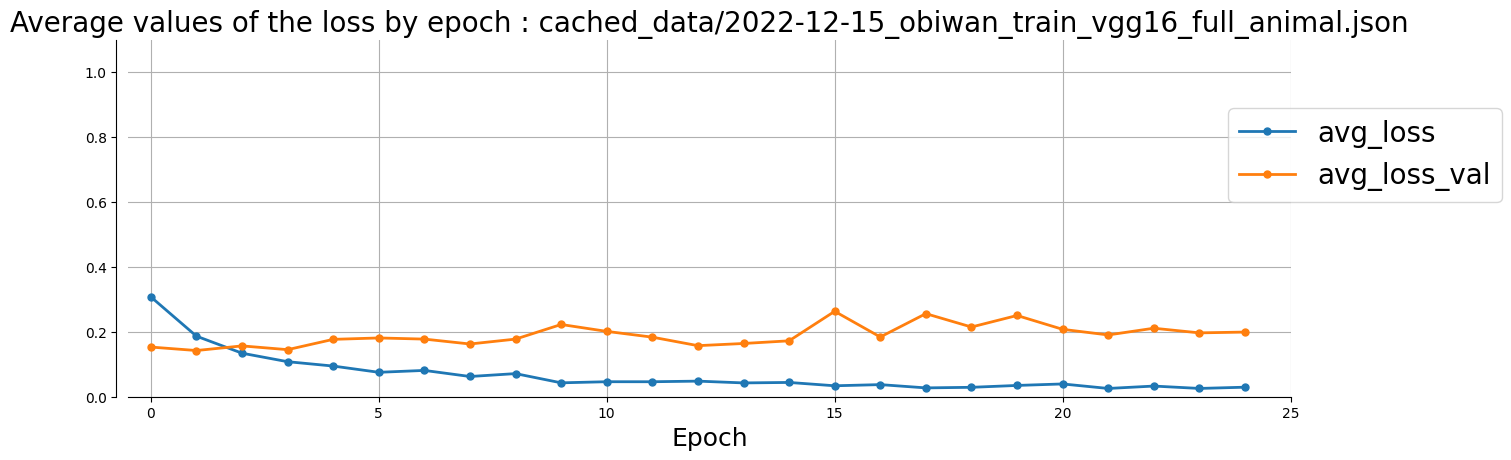

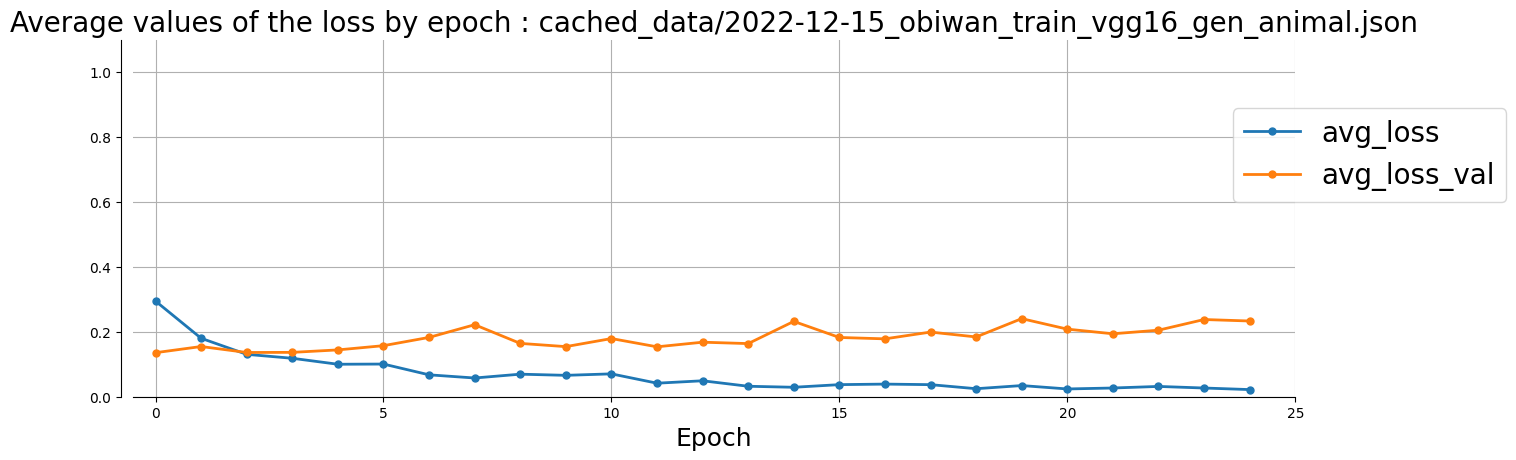

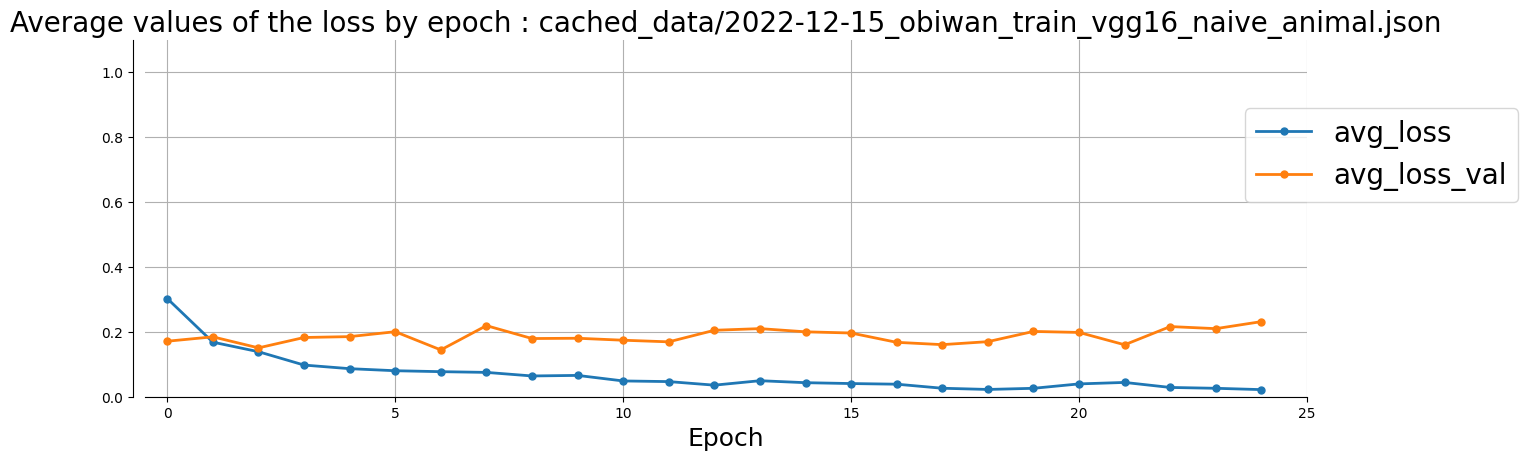

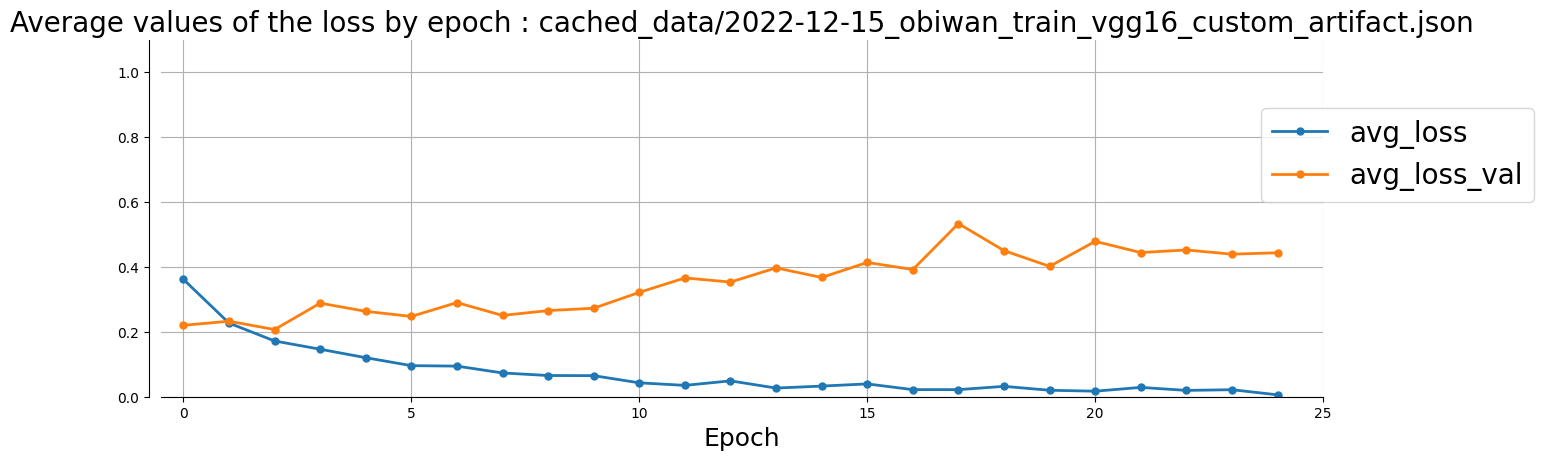

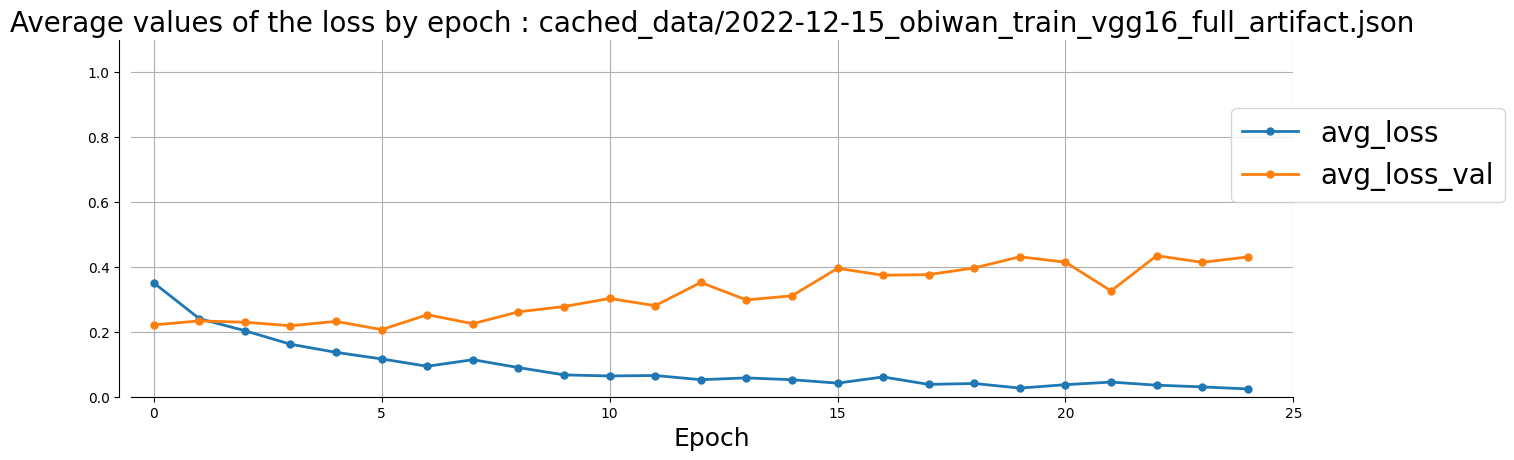

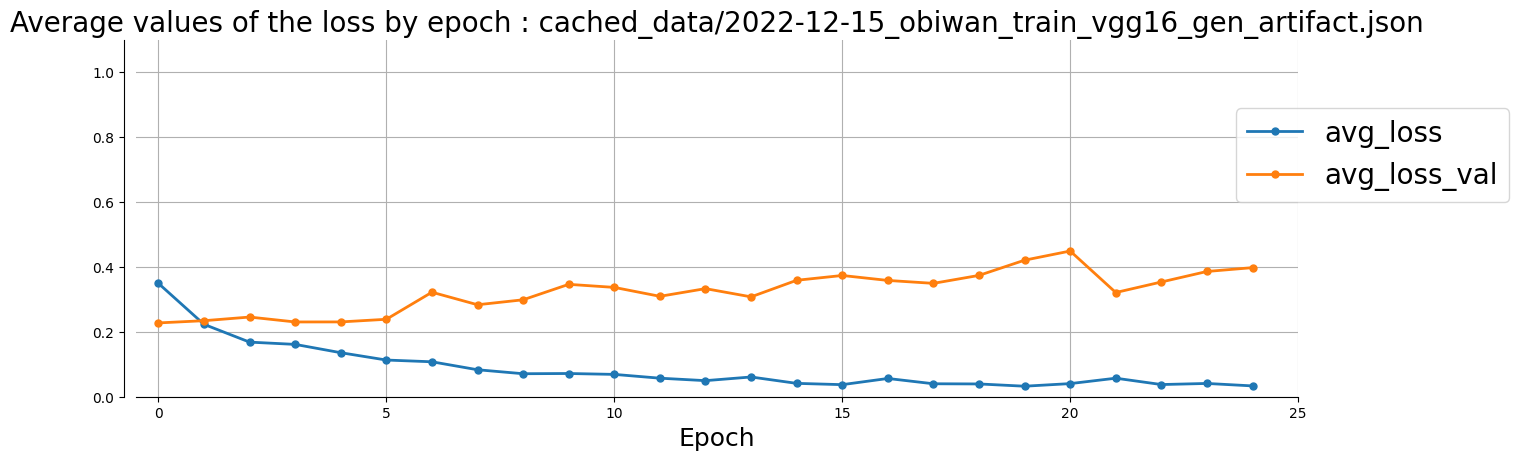

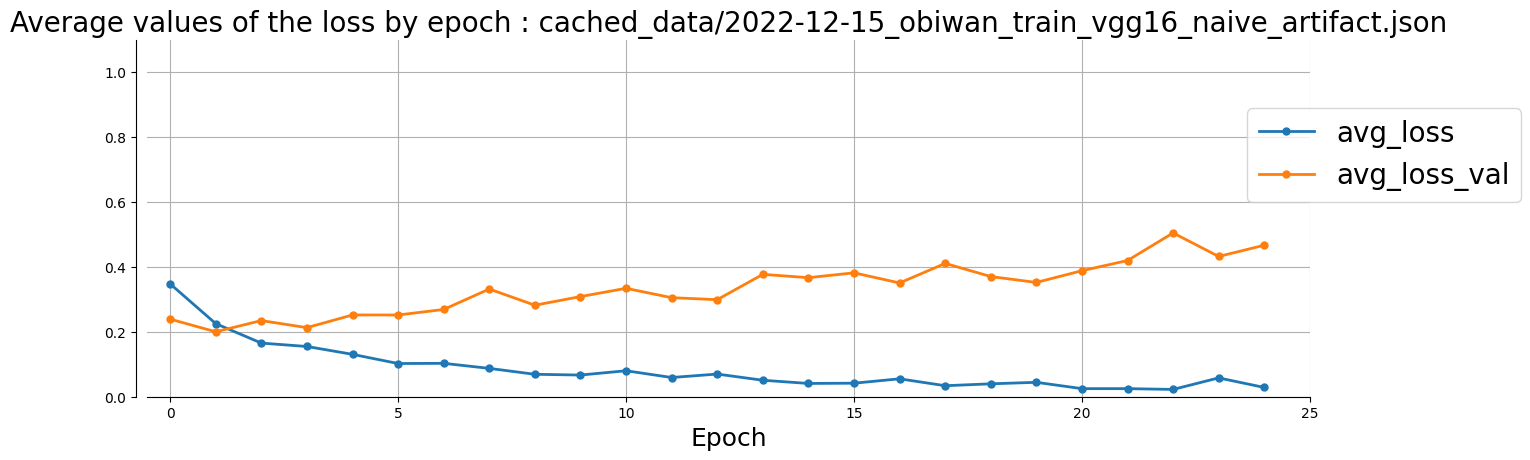

In [17]:
for model_name in all_models:
    filename = f'{data_cache}/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_xlim(-0.5, args.num_epochs)
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    ax.set_ylim(0., 1.1)
    axs.set_title(f'Average values of the loss by epoch : {filename}', fontsize=20)
    ax.get_legend().remove()
    fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize=20)

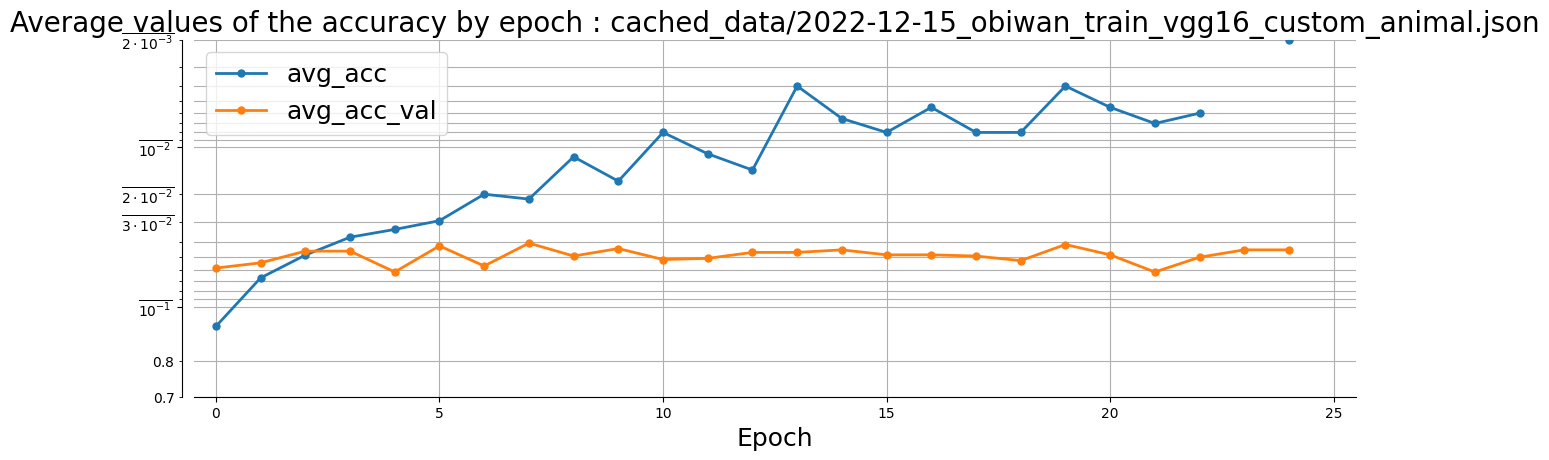

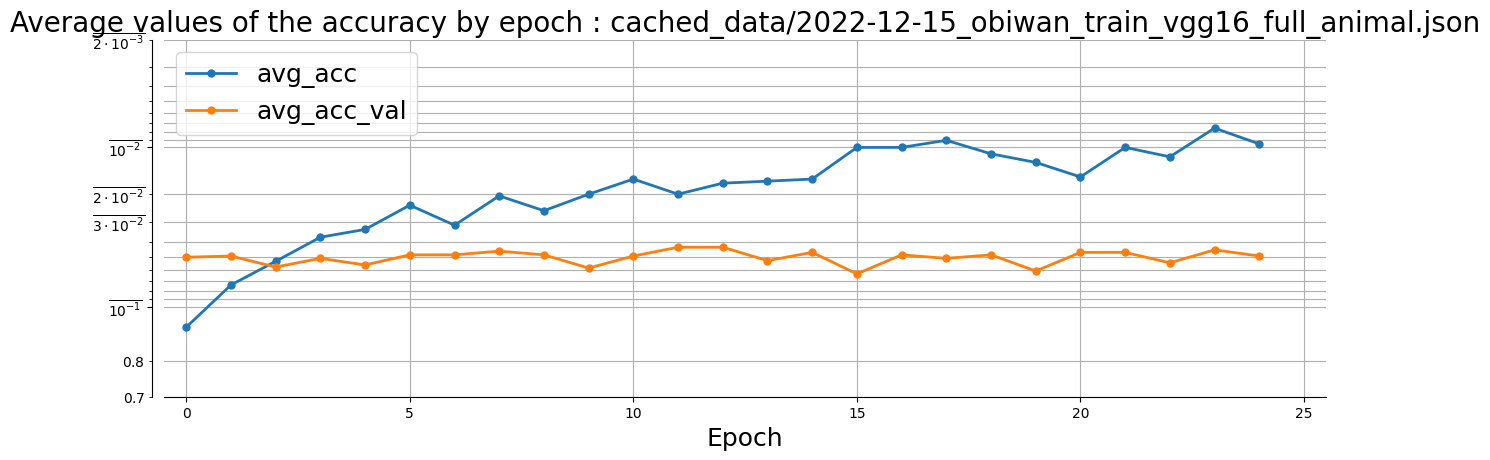

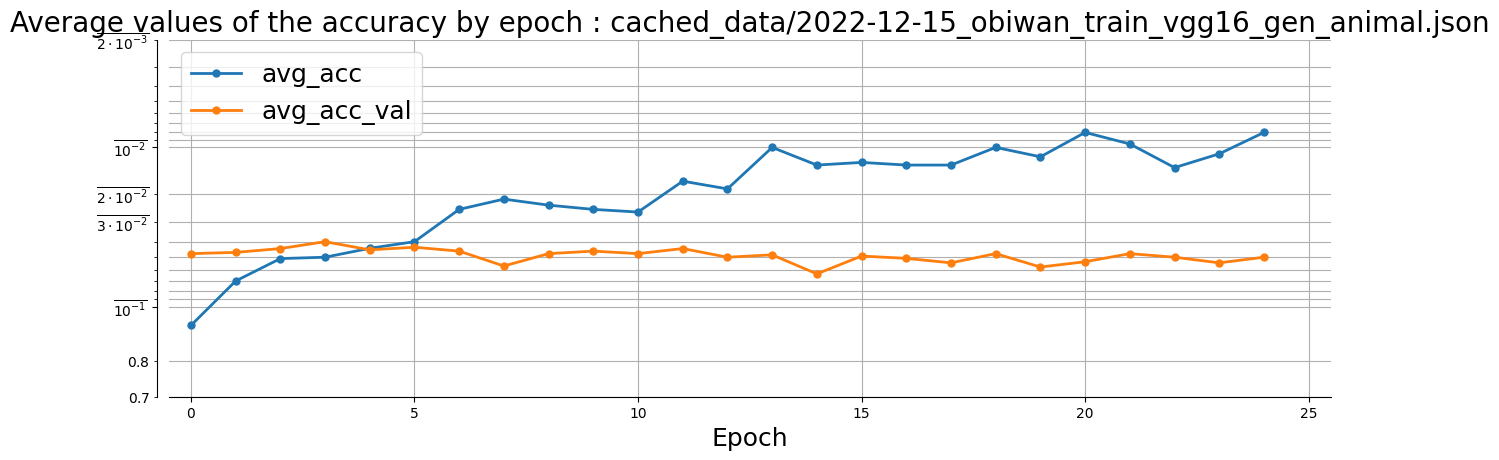

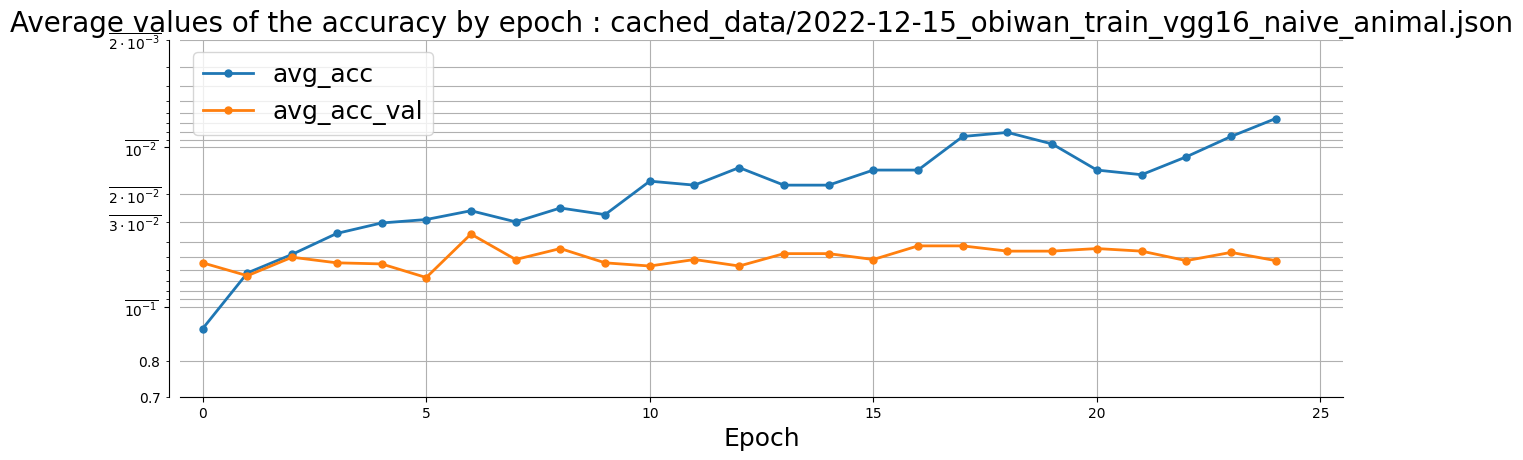

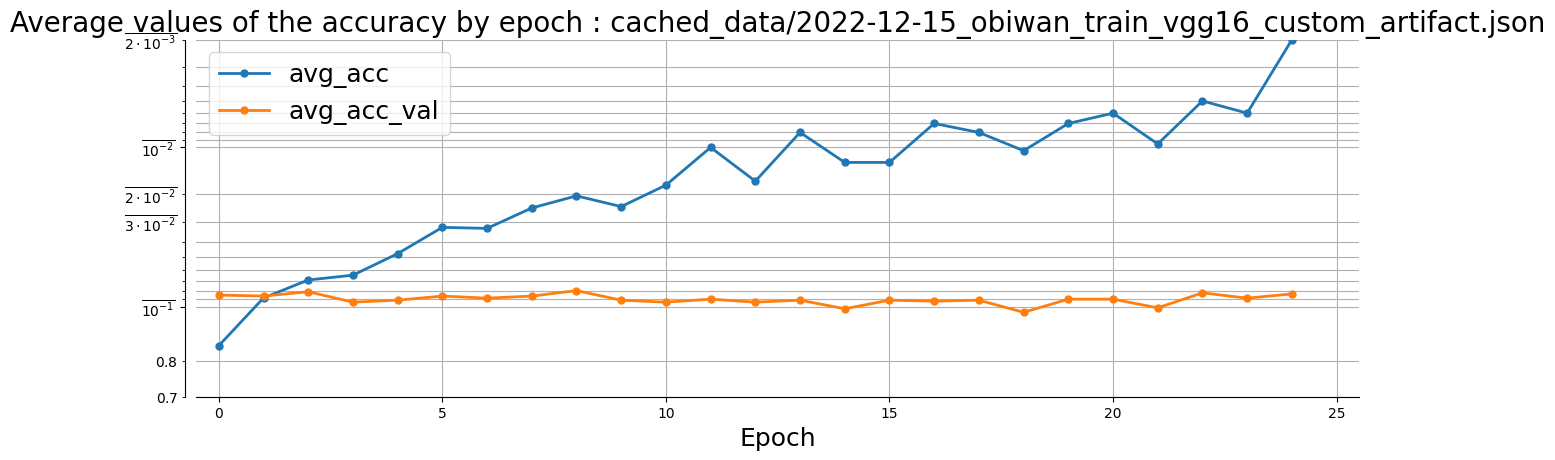

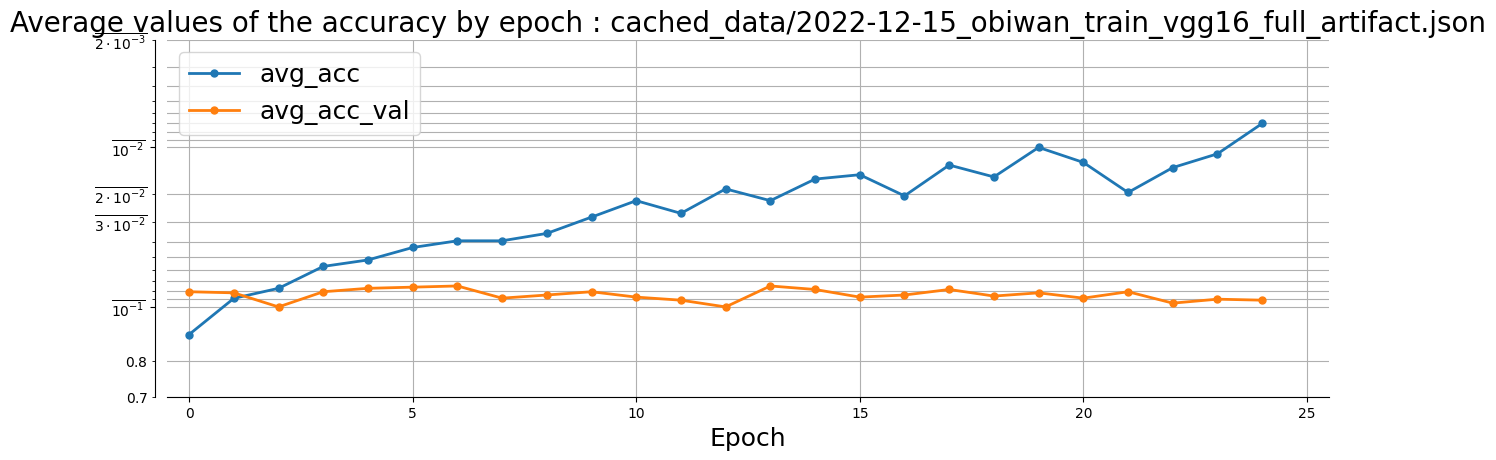

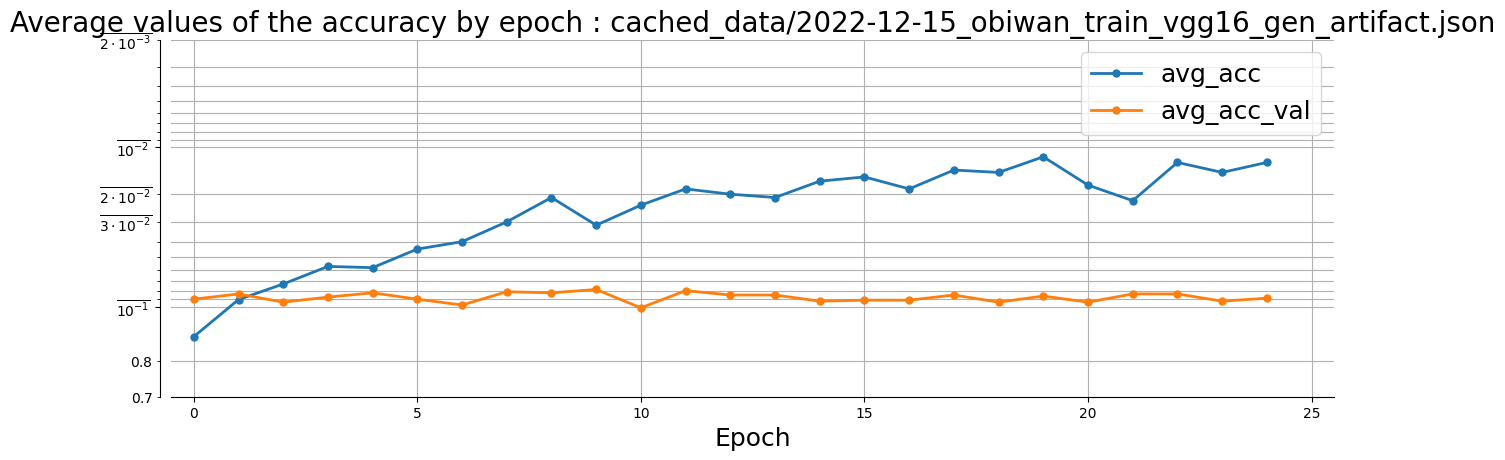

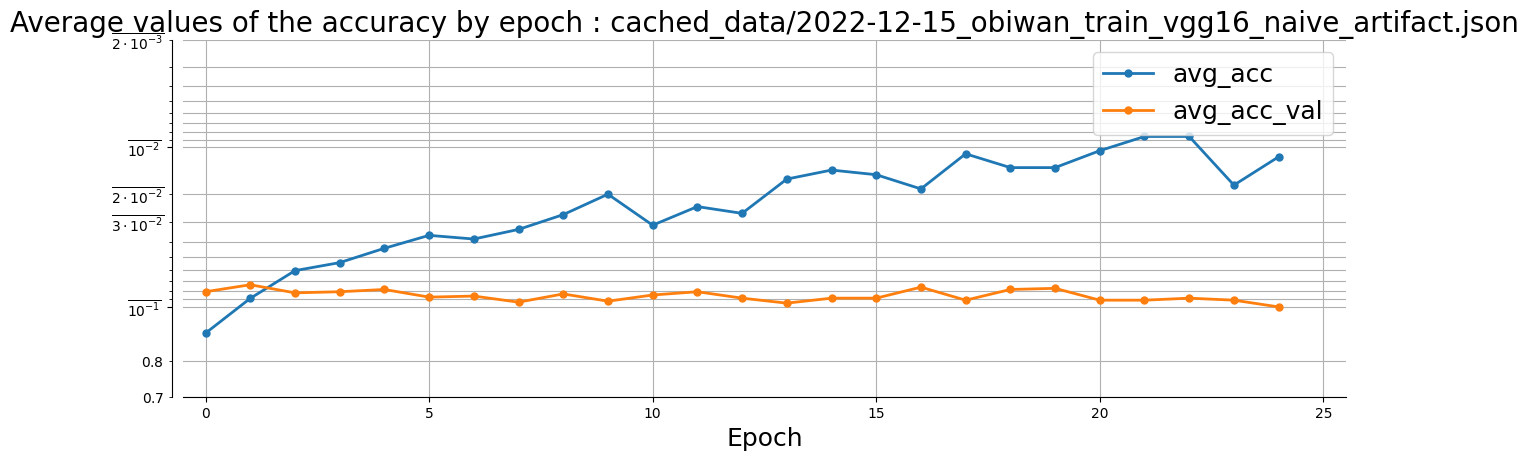

In [18]:
for model_name in all_models:
    filename = f'{data_cache}/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_ylim(0.70, .998)
    ax.set_yscale("logit", one_half="1/2", use_overline=True)
    ax.grid(which='both')
    ax.set_xlim(-0.5, args.num_epochs+.5)
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}', size=20)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);

## Scan of some parameters

In [19]:
scan_dicts = {'batch_size' : [8, 13, 21, 34, 55],
             'lr': args.lr * np.logspace(-1, 1, 7, base=10),
             'momentum': 1 - np.logspace(-2, -.5, 7, base=10),
             'beta2': 1 - np.logspace(-3, -1.5, 7, base=10)
            }

N_val_avg=10


for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{args.HOST}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        i_trial = 0
        measure_columns = [key, 'avg_loss_val', 'avg_acc_val', 'time']

        df_scan = pd.DataFrame([], columns=measure_columns) 
        for i_trial, value in enumerate(scan_dicts[key]):
            new_kwarg = {key: value}
            print('trial', i_trial, ' /', len(scan_dicts[key]))
            print('new_kwarg', new_kwarg)
            # Training and saving the network
            models_vgg_ = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
            # Freeze training for all layers
            # Newly created modules have requires_grad=True by default
            for param in models_vgg_.features.parameters():
                param.requires_grad = False 

            num_features = models_vgg_.classifier[-1].in_features
            features = list(models_vgg_.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, n_output)]) # Add our layer with `n_output` outputs
            models_vgg_.classifier = nn.Sequential(*features) # Replace the model classifier

            since = time.time()
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, p=0, **new_kwarg)
            models_vgg_, df_train = train_model(models_vgg_, num_epochs=args.num_epochs, dataloaders=dataloaders['animal'], **new_kwarg)
            elapsed_time = time.time() - since

            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
            print(df_train)
            df_scan.loc[i_trial] = {key:value, 'avg_loss_val':df_train.iloc[-N_val_avg:-1]['avg_loss_val'].mean(), 
                                'avg_acc_val':df_train.iloc[-N_val_avg:-1]['avg_acc_val'].mean(), 'time':elapsed_time}
            print(df_scan.loc[i_trial])
            i_trial += 1
        df_scan.to_json(filename)


filename='cached_data/2022-12-15_train_scan_batch_size_obiwan.json'
filename='cached_data/2022-12-15_train_scan_lr_obiwan.json'
filename='cached_data/2022-12-15_train_scan_momentum_obiwan.json'
filename='cached_data/2022-12-15_train_scan_beta2_obiwan.json'


In [20]:
type(scan_dicts[key][0])

numpy.float64

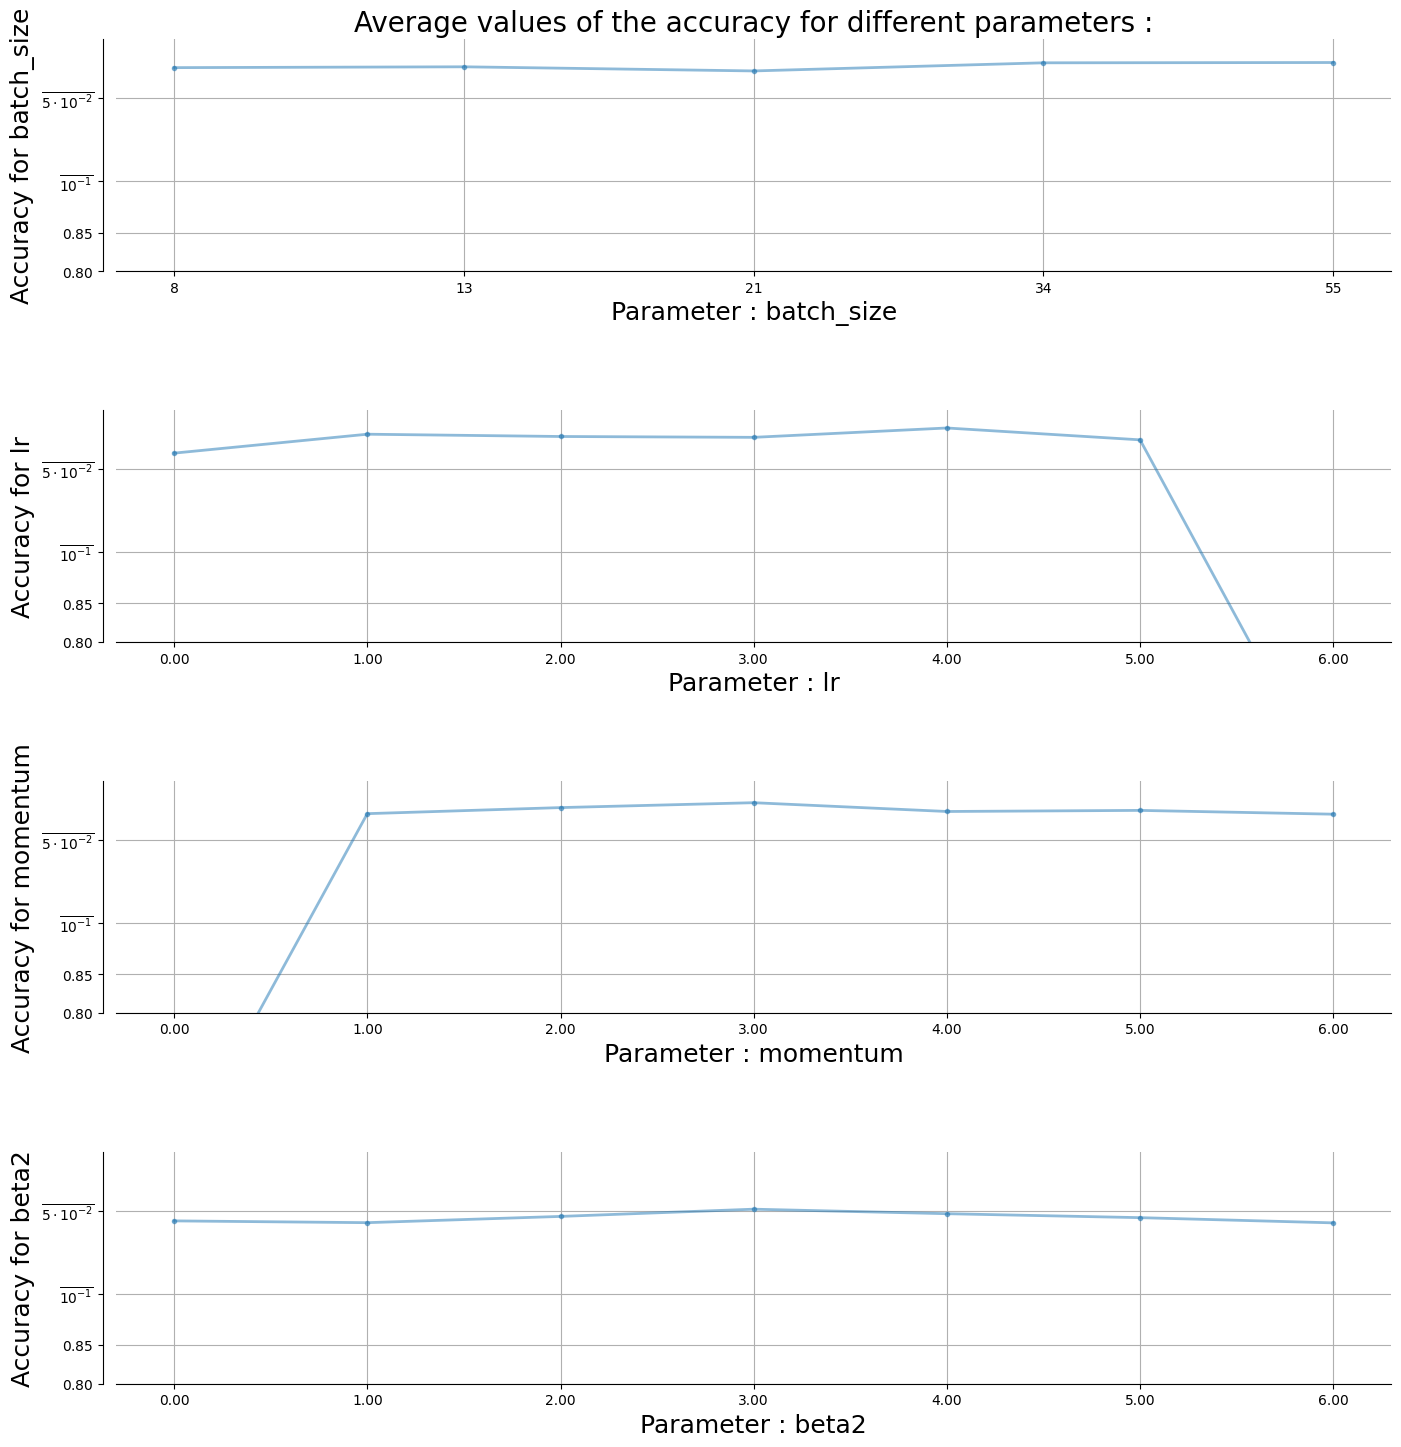

In [21]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter
subplotpars = matplotlib.figure.SubplotParams(left=0.1, right=.95, bottom=0.25, top=.975, hspace=.6)
dfs_ = {}
for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{args.HOST}.json'
    dfs_[str(key)]  = pd.read_json(filename)

fig, axs = plt.subplots(len(dfs_), 1, figsize=(fig_width, fig_width*len(dfs_)/(phi*2)), subplotpars=subplotpars)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10)

for ax, df_train, key in zip(axs, dfs_, scan_dicts):
    ax.plot(range(len(scan_dicts[key])), dfs_[df_train]["avg_acc_val"], alpha=0.5, lw=2, marker='.')
    ax.set_ylabel(f"Accuracy for {key}", size=18)
    ax.set_xlabel(f"Parameter : {key}", size=18)
    ax.set_xticks(range(len(scan_dicts[key])))
    ax.set_xticklabels(scan_dicts[key], size=10)
    # ax.set_xticks(range(len(scan_dicts[key])))
    # ax.set_xticklabels([f'{s:.4f}' for s in scan_dicts[key]], rotation=60, size=20)
    if type(scan_dicts[key][0]) == np.float64: ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_ylim(0.8, .97)
    ax.set_yscale("logit", one_half="1/2", use_overline=True)
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    #ax.get_legend().remove()
axs[0].set_title(f'Average values of the accuracy for different parameters :', size=20);

Plotting losses:

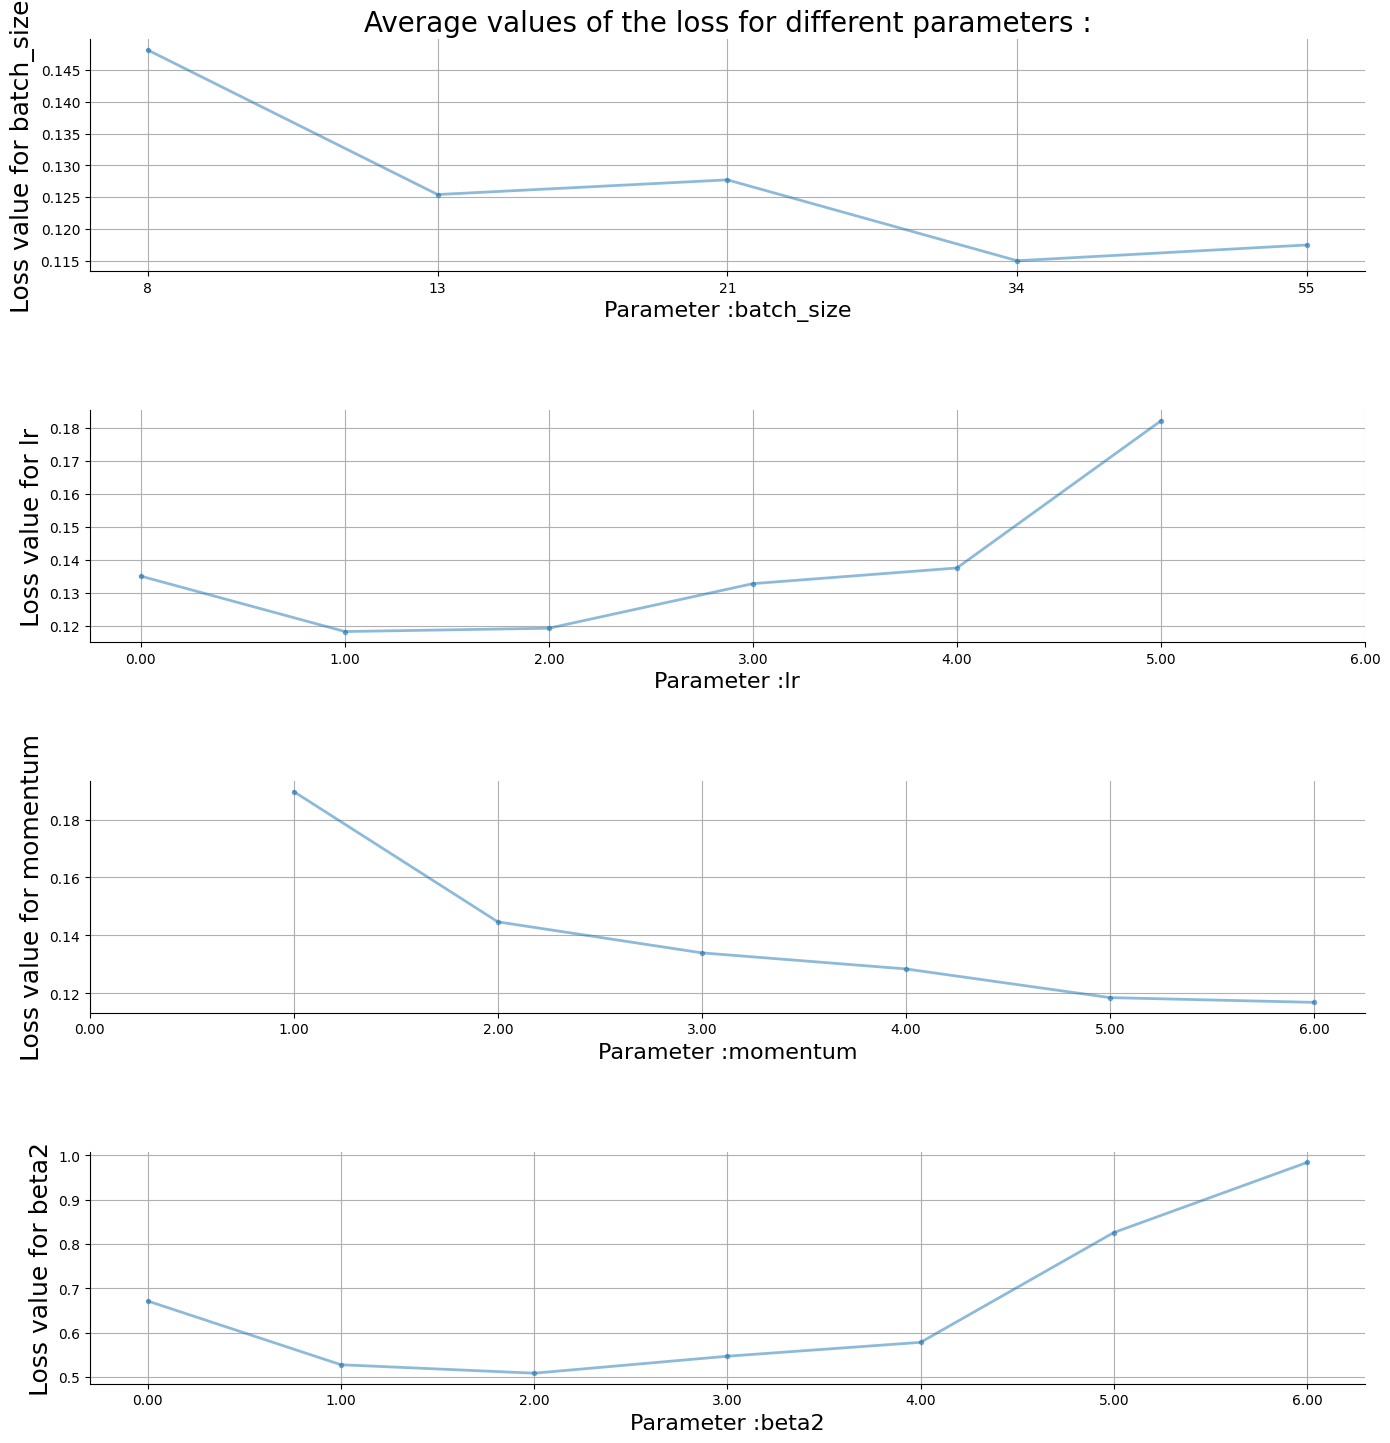

In [ ]:

dfs_ = {}
for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{args.HOST}.json'
    dfs_[str(key)]  = pd.read_json(filename)
fig, axs = plt.subplots(len(dfs_), 1, figsize=(fig_width, fig_width*len(dfs_)/(phi*2)), subplotpars=subplotpars)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10)
for ax, df_train, key in zip(axs, dfs_, scan_dicts):
    ax.plot(range(len(scan_dicts[key])), dfs_[df_train]["avg_loss_val"], alpha=0.5, lw=2, marker='.')
    ax.set_ylabel(f"Loss value for {key}", size=18)    
    ax.set_xlabel(f"Parameter :{key}", size=16)
    ax.set_xticks(range(len(scan_dicts[key])))
    ax.set_xticklabels(scan_dicts[key], size=10)
    if type(scan_dicts[key][0]) == np.float64: ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
axs[0].set_title(f'Average values of the loss for different parameters :', size=20);

## Testing the new networks

Now that the networks seems ready for the comparison. The second part of this notebook offers a comparison between:

- A pre-trained image recognition's networks, here VGG, trained on the [ImageNet](http://image-net.org/) dataset which allows working on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And three re-trained version of the same network VGG16 based on a Wordnet semantic from the ImageNet database which allows working on naturals images for $1$ synsets. 

As a control I re-train networks on the artifact synset too. Another interesting analysis will be the study of the link between the performances on these two conditions. 

<a id="exp1"></a>
## Experiment 1: Image processing and recognition for different labels 

In [23]:
filename = f'{data_cache}/{datetag}_results_basic_{args.HOST}.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    i_trial = 0
    df = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).cpu().squeeze(0)
                    if model_name == 'vgg_16':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0)
                        likelihood = np.asarray(percentage[match[task]]).sum()
                    else:
                        likelihood = torch.sigmoid(out).numpy()[0]
                    top_1 = 'target' if likelihood>0.50 else 'distractor'
                    elapsed_time = time.time() - tic
                df.loc[i_trial] = { 'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 
                                    'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                    'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
                print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
                i_trial += 1
    df.to_json(filename)


filename='cached_data/2022-12-15_results_basic_obiwan.json'


In [24]:
filename = f'{data_cache}/{datetag}_results_basic_{args.HOST}.json'
df = pd.read_json(filename)
df

model          model_task      task        goal  \
0                     vgg_16  Imagenet_challenge    animal  distractor   
1        vgg16_custom_animal              animal    animal  distractor   
2          vgg16_full_animal              animal    animal  distractor   
3           vgg16_gen_animal              animal    animal  distractor   
4         vgg16_naive_animal              animal    animal  distractor   
...                      ...                 ...       ...         ...   
21604     vgg16_naive_animal              animal  artifact      target   
21605  vgg16_custom_artifact            artifact  artifact      target   
21606    vgg16_full_artifact            artifact  artifact      target   
21607     vgg16_gen_artifact            artifact  artifact      target   
21608   vgg16_naive_artifact            artifact  artifact      target   

       likelihood         fps      time  i_image  \
0        0.090458    5.506128  0.181616        0   
1        0.026258   13.764046  0.072653        0   
2        0.090891   12.039071  0.083063        0   
3        0.021275   31.264612  0.031985        0   
4        0.032943   12.668016  0.078939        0   
...           ...         ...       ...      ...   
21604    0.000123  103.573291  0.009655     1199   
21605    1.000000  130.655535  0.007654     1199   
21606    0.999858  120.918615  0.008270     1199   
21607    0.999964  113.568288  0.008805     1199   
21608    0.999992  116.102087  0.008613     1199   

                                                filename       top_1  
0      ../data/animal/test/distractor/008dfb4aa73cf26...  distractor  
1      ../data/animal/test/distractor/008dfb4aa73cf26...  distractor  
2      ../data/animal/test/distractor/008dfb4aa73cf26...  distractor  
3      ../data/animal/test/distractor/008dfb4aa73cf26...  distractor  
4      ../data/animal/test/distractor/008dfb4aa73cf26...  distractor  
...                                                  ...         ...  
21604  ../data/artifact/test/target/ff0ff0969e045aa90...  distractor  
21605  ../data/artifact/test/target/ff0ff0969e045aa90...      target  
21606  ../data/artifact/test/target/ff0ff0969e045aa90...      target  
21607  ../data/artifact/test/target/ff0ff0969e045aa90...      target  
21608  ../data/artifact/test/target/ff0ff0969e045aa90...      target  

[21609 rows x 10 columns]

### Summary

#### Computation Time

/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_36167/817720071.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


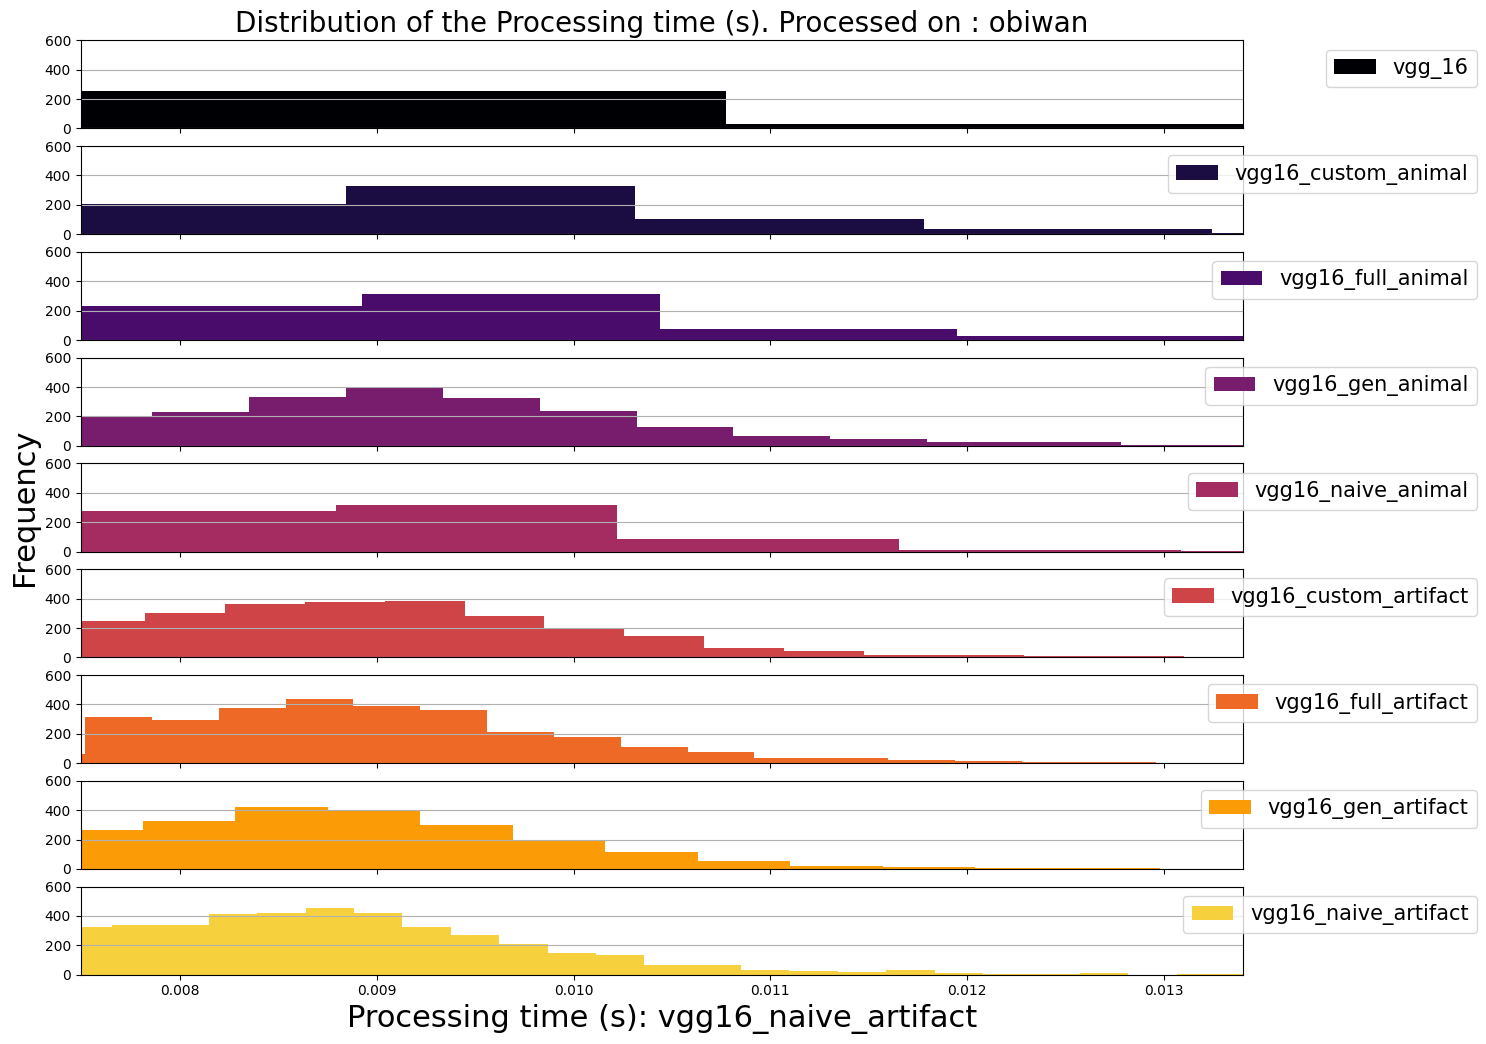

In [25]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2), sharex=True, sharey=True)
cmap = plt.cm.get_cmap('inferno')
color_dict = pd.Series({k:cmap(i/len(df['model'].unique())) for i,k in enumerate(df['model'].unique())})
for ax, color, model_name in zip(axs, color_dict, models_vgg):
    df[df['model']==model_name]['time'].plot.hist(bins=50, lw=1, label=model_name,ax=ax, color=[color_dict[model_name],], density=True)
    ax.set_xlim(df['time'].quantile(.01), df['time'].quantile(.99))
    ax.set_ylim(0, 600)
    ax.legend(bbox_to_anchor=(1.21, .35), loc='lower right', fontsize=15)
    ax.grid(which='both', axis='y')
    ax.set_xlabel('Processing time (s): ' + model_name, size=22)
    ax.set_ylabel('')
axs[0].set_title('Distribution of the Processing time (s). Processed on : ' + args.HOST, size=20)
axs[len(models_vgg)//2].set_ylabel('Frequency', fontsize=22);

#### Accuracy comparison for all the models

In [26]:
from sklearn.metrics import accuracy_score, f1_score

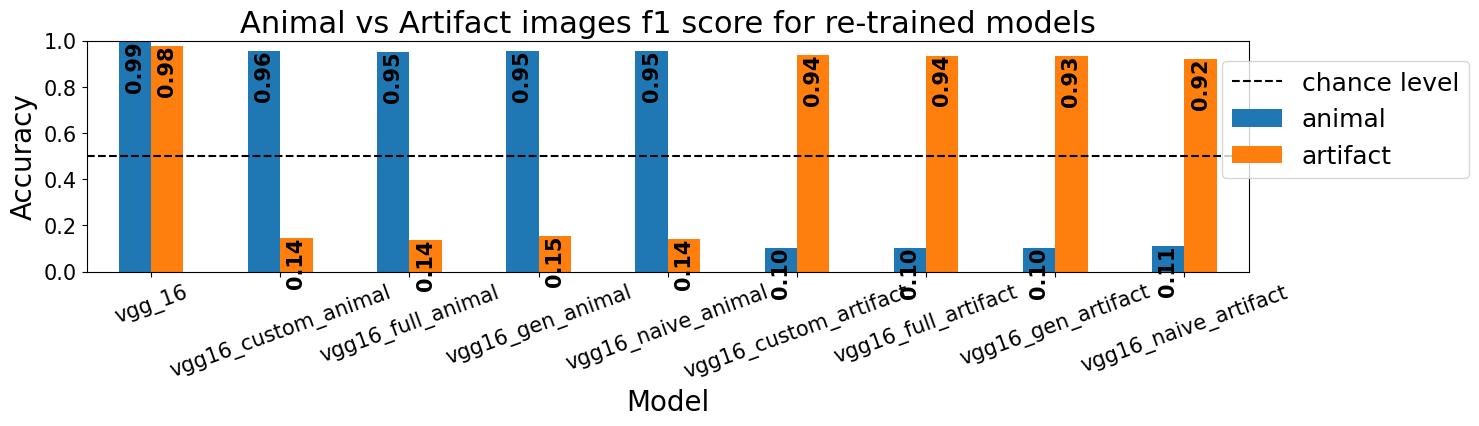

In [27]:
df_acc = pd.DataFrame({model_name: {task: accuracy_score(df[(df['model']==model_name) & (df['task']==task)]["top_1"], 
                                                             df[(df['model']==model_name) & (df['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df['model'].unique()})

ax = df_acc.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=fontsize)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-36, color='black', fontsize=fontsize, fmt='%.2f', weight='bold', rotation=90)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_36167/1034827554.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')
/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_36167/1034827554.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(labels=['Vgg ImageNet','Vgg Animal','Vgg Artifact'], font=font)
/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_36167/1034827554.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)
/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_36167/1034827554.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(labels=['V

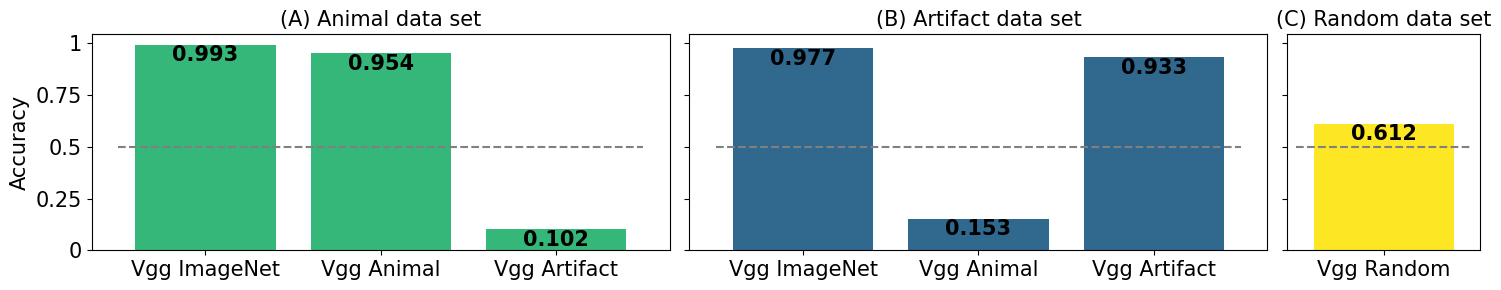

In [28]:

acc_dict = df_acc.to_dict()

model_tested = ['Vgg ImageNet', 'Vgg Animal', 'Vgg Artifact']
fig, axs = plt.subplots(1, len(model_tested), sharex=False, sharey=True, figsize=(fig_width, fig_width//4)
                       ,gridspec_kw={'width_ratios': [3, 3,1]})
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(model_tested)) for i,k in enumerate(model_tested)})
titles = ["(A) Animal data set", "(B) Artifact data set" ,"(C) Random data set" ]

F1_Random = .612
data_rand = { 'x_abs': ['Vgg Random'],
        'y_val' : [ F1_Random]}
data_ani = { 'x_abs': ['Vgg ImageNet', 'Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg_16']['animal'], acc_dict['vgg16_gen_animal']['animal'], acc_dict['vgg16_gen_artifact']['animal']]}
data_art = { 'x_abs': ['Vgg ImageNet', 'Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg_16']['artifact'], acc_dict['vgg16_gen_animal']['artifact'], acc_dict['vgg16_gen_artifact']['artifact']]}
df_rand = pd.DataFrame(data_rand)
df_ani = pd.DataFrame(data_ani)
df_art = pd.DataFrame(data_art)

axs[2].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color= color_dict[0])
axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color= color_dict[1])
axs[1].bar(df_art['x_abs'], df_art['y_val'], color= color_dict[2])
axs[2].hlines(xmin=-.5, xmax=.5, y=1/2, ls='--', ec='gray')
axs[0].hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='gray')
axs[1].hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='gray')
axs[0].set_xticklabels(labels=['Vgg ImageNet','Vgg Animal','Vgg Artifact'], font=font)
axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)
axs[1].set_xticklabels(labels=['Vgg ImageNet','Vgg Animal','Vgg Artifact'], font=font)
axs[0].set_ylabel('Accuracy', font=font)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for j, ax in enumerate(axs):
    ax.set_title(titles[j], font=font)
    ax.tick_params(axis='both', labelsize=15)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, padding=-15, color='black', fmt='%.3f', rotation=0, label_type = 'edge', fontsize=fontsize, weight='bold')

        
plt.xticks(font=font)
plt.yticks(font=font)        
plt.tight_layout()
if do_savefig: fig.savefig(os.path.join(figpath, 'mean_accuracy.pdf'), **opts_savefig)

### limiting our classification to Strictly animal / artifact

In [29]:
filename = f'{data_cache}/{datetag}_results_strictly_basic_{HOST}.json'
print(f'{filename=}')
paths['animal']['test'] = '../data/strictly_animal/test'
paths['artifact']['test'] = '../data/strictly_artifact/test'
if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    i_trial = 0
    df = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    if model_name == 'vgg_16':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        likelihood = np.asarray(percentage[match[task]].cpu()).sum()
                    else:
                        likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if likelihood>50 else 'distractor'
                    elapsed_time = time.time() - tic
                df.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                        'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
                i_trial += 1
    df.to_json(filename)

filename='cached_data/2022-12-15_results_strictly_basic_obiwan.json'
------
animal
------
The vgg_16 model categorize Imagenet_challenge with 1.247 % likelihood (distractor) in 0.674 seconds, groundtrue : animal, distractor
The vgg16_custom_animal model categorize animal with 0.001 % likelihood (distractor) in 0.616 seconds, groundtrue : animal, distractor
The vgg16_full_animal model categorize animal with 0.092 % likelihood (distractor) in 0.589 seconds, groundtrue : animal, distractor
The vgg16_gen_animal model categorize animal with 0.041 % likelihood (distractor) in 0.597 seconds, groundtrue : animal, distractor
The vgg16_naive_animal model categorize animal with 0.095 % likelihood (distractor) in 0.589 seconds, groundtrue : animal, distractor
The vgg16_custom_artifact model categorize artifact with 100.000 % likelihood (target) in 0.610 seconds, groundtrue : animal, distractor
The vgg16_full_artifact model categorize artifact with 99.980 % likelihood (target) in 0.580 seconds, gro

In [ ]:
df_strictly = pd.read_json(filename)
df_strictly

In [ ]:
df_acc_strickly = pd.DataFrame({model_name: {task: accuracy_score(df_strictly[(df_strictly['model']==model_name) & (df_strictly['task']==task)]["top_1"], 
                                                               df_strictly[(df_strictly['model']==model_name) & (df_strictly['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df_strictly['model'].unique()})

ax = df_acc_strickly.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=20)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f')
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

In [ ]:
df_acc = pd.DataFrame({model_name: {task: accuracy_score(df[(df['model']==model_name) & (df['task']==task)]["top_1"], 
                                                             df[(df['model']==model_name) & (df['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df['model'].unique()})

In [ ]:
acc_dict = df_acc.to_dict()
acc_dict_s = df_acc_strickly.to_dict()
fig_width = 15
model_tested = [ 'Random', 'Animal', 'Artifact']
fig, axs = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(fig_width, fig_width/5)
                       ,gridspec_kw={'width_ratios': [2, 2, 2, 2, 1]})
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(model_tested)) for i,k in enumerate(model_tested)})
titles = ["(A) Animal set",  "(B) Strictly Animal set", "(C) Artifact set" , "(D) Strictly Artifact set", "(E) Random set" ]

F1_Random = .612
data_rand = { 'x_abs': ['Vgg Random'],
        'y_val' : [ F1_Random]}
data_ani = { 'x_abs': ['Animal', 'Artifact'],
             'y_val' : [acc_dict['vgg16_gen_animal']['animal'], acc_dict['vgg16_gen_artifact']['animal']]}
data_art = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg16_gen_animal']['artifact'], acc_dict['vgg16_gen_artifact']['artifact']]}
data_ani_s = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict_s['vgg16_gen_animal']['animal'], acc_dict_s['vgg16_gen_artifact']['animal']]}
data_art_s = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict_s['vgg16_gen_animal']['artifact'], acc_dict_s['vgg16_gen_artifact']['artifact']]}

df_rand = pd.DataFrame(data_rand)
df_ani = pd.DataFrame(data_ani)
df_art = pd.DataFrame(data_art)
df_ani_s = pd.DataFrame(data_ani_s)
df_art_s = pd.DataFrame(data_art_s)



axs[4].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color= color_dict[0])
axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color= (color_dict[1], color_dict[2]))
axs[2].bar(df_art['x_abs'], df_art['y_val'], color= (color_dict[1], color_dict[2]))
axs[1].bar(df_ani_s['x_abs'], df_ani_s['y_val'], color= (color_dict[1], color_dict[2]))
axs[3].bar(df_art_s['x_abs'], df_art_s['y_val'], color= (color_dict[1], color_dict[2]))


axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)

axs[0].set_ylabel('Accuracy', fontsize = fontsize)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for j, ax in enumerate(axs):
    axs[j].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray') if j != 4 else axs[j].hlines(xmin=-.5, xmax=.5, y=1/2, ls='--', ec='gray')  
    axs[j].set_xticklabels(labels=['Animal','Artifact'], font=font) if j != 4 else axs[j].set_xticklabels(labels=['VGG Random'], font=font) 
    ax.set_title(titles[j], fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, padding=-15, color='black', fontsize=fontsize, fmt='%.3f', rotation=0, label_type = 'edge', fontweight='bold')

    
plt.xticks(font=font)
plt.yticks(font=font)        
plt.tight_layout()
if do_savefig: fig.savefig(os.path.join(figpath, 'mean_accuracy.pdf'), **opts_savefig)

#### Conclusion

We tested the networks Vgg Gen, Vgg Scale and Vgg Gray trained to detect an animal on the dataset where the targets are 'animal' (respectively train to detect an artifact on dataset where targets are artifacts). Then we tested the networks trained to detect an 'animal' on the dataset where the targets are 'artifact' and vice versa. Here, by exposing the predictions for the 'animal' and 'artifact' labels, we highlight a bias in the composition of the dataset. Although the outputs are independent, 'animal' images confidently correspond to 'non-artifact' images (and vice versa), thus facilitating the overall detection.

<a id="exp2"></a>
## Experiment 2: Image processing and recognition for differents flip transformations

In [ ]:
flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1)
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)

filename = f'{data_cache}/{datetag}_results_flip_{args.HOST}.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    i_trial = 0
    df_flip = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'flip'])   
    # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for flip in flips:
        pprint(flip)
        for task in args.tasks:
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = flips[flip](data)
                data, label, = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        tic = time.time()
                        out = model(data).squeeze(0).cpu()
                        if model_name == 'vgg_16':
                            model_task = 'Imagenet_challenge'
                            percentage = torch.nn.functional.softmax(out, dim=0)
                            likelihood = np.asarray(percentage[match[task]]).sum()
                        else:
                            likelihood = torch.sigmoid(out).numpy()[0]
                        elapsed_time = time.time() - tic
                        top_1 = 'target' if likelihood>0.50 else 'distractor'
                    df_flip.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal,        
                                            'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                            'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'flip':flip}
                    print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
                    i_trial += 1

    df_flip.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_flip_{args.HOST}.json'
df_flip = pd.read_json(filename)

### Summary

#### Computation Time

In [ ]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="flip", y="time", data=df_flip, inner="quartile", hue='model')
    axs.set_title('Processing time (s) for each network at different image size. Processed on : ' + args.HOST, size=20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Image size', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

#### Accuracy comparison for all the models

In [ ]:
flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1)
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)

for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {flip: accuracy_score(df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip) ]["top_1"], 
                                                                   df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip)]["goal"])
                                        for flip in flips} 
                           for model_name in models_vgg})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='gray', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=fontsize, weight='bold', fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

#### Conclusion

We tested the Vgg Gen network on the ImageNet dataset with either a vertical or horizontal reflection applied on the input. The networks keeps a good mean accuracy on the flipped dataset (about 95%).

<a id="exp4"></a>
## Experiment 4: Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [ ]:
filename = f'{data_cache}/{datetag}_results_grayscale_{args.HOST}.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df_gray = pd.read_json(filename)
else:
    i_trial = 0
    df_gray = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1, p=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).squeeze(0).cpu()
                    if model_name == 'vgg_16':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0)
                        likelihood = np.asarray(percentage[match[task]]).sum()
                    else:
                        likelihood = torch.sigmoid(out).numpy()[0]
                    top_1 = 'target' if likelihood>0.50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_gray.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                        'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
                print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
                i_trial += 1
    df_gray.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_grayscale_{args.HOST}.json'
df_gray = pd.read_json(filename)

### Summary

#### Computation time

In [ ]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg):
        ax.set_ylabel('Frequency', fontsize=20) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
        ax.legend(bbox_to_anchor=(1.18, .35), loc='lower right')
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST, size=20);

#### Accuracy

In [ ]:
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {label: accuracy_score(df_[(df_['model']==model_name) & (df_['task']==task)]["top_1"], 
                                                                   df_[(df_['model']==model_name) & (df_['task']==task)]["goal"])
                                        for label, df_ in zip(['original', 'gray'], [df, df_gray])} 
                           for model_name in models_vgg})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=18)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='gray', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=fontsize, weight='bold', fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.16, .35), loc='lower right', fontsize=16)
    ax.grid(which='both', axis='y')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    ax.set_title(f'Experiment - color vs gray images, task: {task}', size=20)
    ax.set_ylabel('F1 Score', size=18)
    plt.show();

#### Conclusion

We tested the networks on the ImageNet dataset with a grayscale filter applied on the input. The networks keeps a good mean accuracy on the grayscale dataset (about 94%). Note that the Vgg Gray networks achieves the task with a gray scale applied with a sightly better mean accuracy ([experiment 4](#exp4)) but not on the regular 'test' dataset ([experiment 1](#exp1)).

<a id="exp5"></a>
## Experiment 5: Image processing and recognition on rotated images :

In addition we tested all networks on our IMAGENET dataset while rotating the image around the center by -180° to +180°.

In [ ]:
import numpy as np 
np.arange(-180, 181, 15)

In [ ]:
angles = np.arange(-180, 181, 15)
filename = f'{data_cache}/{datetag}_results_rotate_{args.HOST}.json'
print(f'{filename=}')
   
if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    i_trial = 0
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=25)
    # image preprocessing
    for task in args.tasks:
        print(task)
        for angle in angles:
            print(f'Rotation by {angle=}°')
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                acc_= 0
                for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                    data = transforms.functional.rotate(data, angle=float(angle), expand = True)
                    data, label, = data.to(device), label.to(device)
                    with torch.no_grad():
                        outputs = model(data)
                        if model_name == 'vgg_16':
                            percentage = torch.nn.functional.softmax(outputs, dim=1)
                            preds = torch.sum(percentage[:, match[task]], dim=1)
                            acc_ += torch.sum(torch.round(preds) == label.data)
                        else:
                            preds = torch.round(torch.sigmoid(outputs[:,0].data))
                            acc_ += torch.sum(preds == label.data)
                avg_acc = acc_ / dataset_sizes[task]['test']
                df_angle.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':angle}  
                print(model_name, float(avg_acc), angle)
                #print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
                i_trial += 1
                # if device=='cuda': torch.cuda.empty_cache()
    df_angle.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_rotate_{args.HOST}.json'

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
    df_angle_animal = df_angle[:len(df_angle)//2]
    df_angle_artifact = df_angle[len(df_angle)//2:]

In [ ]:
if os.path.isfile(filename):
    fig, ax = plt.subplots(figsize=(10, 5))
    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(df_angle_artifact['model'].unique())) for i,k in enumerate(df_angle_artifact['model'].unique())})

    for model_name in df_angle['model'].unique():     
        df_angle_artifact[(df_angle_artifact['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                            marker='o', lw=0, label=model_name, ax=ax)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0.5, 1)
    ax.set_xlim(-185, 185)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_ylabel('Mean Accuracy', font=font)
    ax.set_xlabel('Rotation (°)', font=font)

    plt.legend(bbox_to_anchor=(1.28, .5), loc='center', fontsize=10, prop=font)
    plt.xticks(font=font)
    plt.yticks(font=font);

In [ ]:
if os.path.isfile(filename):

    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(df_angle_animal['model'].unique())) for i,k in enumerate(df_angle_animal['model'].unique())})

    for model_name in df_angle['model'].unique():     
        df_angle_animal[(df_angle_animal['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                            marker='o', lw=0, label=model_name, ax=ax)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0.5, 1)
    ax.set_xlim(-185, 185)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_ylabel('Mean Accuracy', font=font)
    ax.set_xlabel('Rotation (°)', font=font)
    plt.legend(bbox_to_anchor=(1.28, .5), loc='center', fontsize=10, prop=font)
    plt.xticks(font=font)
    plt.yticks(font=font);

In [ ]:
color_dict

In [ ]:
if os.path.isfile(filename):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    grphe1 = ['vgg_16', 'vgg16_gen_animal']
    grphe2 = ['vgg16_gen_animal', 'vgg16_custom_animal']
    all_ = ['temp', 'vgg_16', 'temp', 'vgg16_gen_animal', 'temp', 'vgg16_custom_animal']
    all_ = ['temp', 'vgg_16', 'temp', 'vgg16_gen_animal', 'temp', 'vgg16_custom_animal']

    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(all_)) for i,k in enumerate(all_)})
    label_dict = {'vgg_16':'VGG16', 'vgg16_gen_animal':'VGG Gen', 'vgg16_custom_animal':'VGG Custom'}

    graphes = [grphe1, grphe2]
    for ax, graphe in zip(axs, graphes):
        for model_name in graphe:
            df_angle_model = (df_angle_animal['model']==model_name)
            # df_angle_animal[df_angle_model].plot.scatter(x="var", y="mean_prediction", 
            #                                              c=[color_dict[model_name]],
            #                                              marker='o', label=label_dict[model_name], lw=2., ax=ax)
            df_angle_animal[df_angle_model].plot(x="var", y="mean_prediction", 
                                                         color=[color_dict[model_name]],
                                                         marker='o', label=label_dict[model_name], lw=2., ax=ax)
                                                                
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(0.5, 1)
        ax.set_xlim(-185, 185)
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_ylabel('Accuracy', font=font)
        ax.set_xlabel('Rotation (°)', font=font)
        ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([.5, .75, 1]))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_font(font)
        # ax.get_legend().remove()
        # ax_dict['top'].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        #               ncol=2, mode="expand", borderaxespad=0.)
        ax.legend(loc='lower left', fontsize=18, edgecolor='none')

    if do_savefig: fig.savefig(os.path.join(figpath, 'full_rot.pdf'), **opts_savefig)

#### Conclusion

The image size or a gray filter during training does not seem to impact the robustness to rotation as all three networks follow the same accuracy level for the categorization. Furthermore,
these three networks maintain a good accuracy during the process (VGG GEN 90.272 +/- 2.05, VGG GRAY 89.464 +/-2.72, VGG SCALE 89.222: +/- 2.722) (see Figure 5). As the networks seems robust to relection [experiment 2](#exp2), to the resolution [experiment 3](#exp3) (in a short range centered in the training resolution) and to grayscale [experiment 4](#exp4), the robustness of the categorization to different image transformations by the models are similar to that reported in psychophysics. 

## Imagenet rotation 

In [ ]:
def CleanRotation_function(image, angle=0, radius=0.5, mask_exponent=3, image_size=args.image_size):

    image_rot = transforms.functional.rotate(image, angle=angle, expand=False)

    X, Y = np.meshgrid(np.linspace(-radius, radius, image_size, endpoint=True), 
           np.linspace(-radius, radius, image_size, endpoint=True))
    R = np.sqrt(X**2 + Y**2)
    mask =  ((R < 0.5) * ((np.cos(np.pi*R/radius)+1)/2)**(1./mask_exponent) )> 0
    
    return image_rot[:,::]*torch.from_numpy(mask)

def imshow(img_list, title=None): #allow to display the input image
    images = torchvision.utils.make_grid(img_list)
    fig = plt.figure(figsize=(5*len(img_list),5))
    """Imshow for Tensor."""
    inp = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.xticks([]) ; plt.yticks([])
    if title is not None: plt.title(title)
    plt.tight_layout()
    plt.show()
    
match['random'] = []
random_file = '{data_cache}/random_choice_distractors.json'
if os.path.exists(random_file):
    print('Random mode : Using last random selection')
    with open(random_file) as f:
        class_wnids = list(json.load(f))
    for i_img, img_id in enumerate(Imagenet_urls_ILSVRC_2016):
        if img_id[:9] not in class_wnids:
            match['random'].append(i_img)

filename = f'{data_cache}/{datetag}_results_rotate_imagenet_new_{args.HOST}.json'
print(f'{filename=}')
tasks = args.tasks
tasks.append('random')
paths['random'] = {}
for folder in args.folders:
    paths['random'][folder] = os.path.join(args.root, task, folder) # data path

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    i_trial = 0
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var', 'effect'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=25)
    # image preprocessing
    for task in tasks:
        print(task)
        for effect in ['basic', 'rot', 'rot_custom']:
            model_name = 'vgg_16'
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                if effect == 'rot':
                    data = transforms.functional.rotate(data, angle=float(random.choice(angles)), expand = True)
                if effect == 'rot_custom':
                    data = CleanRotation_function(data, angle=float(random.choice(angles)), image_size=args.image_size)
                data, label, = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    percentage = torch.nn.functional.softmax(outputs, dim=1)
                    preds = torch.sum(percentage[:,match[task]], dim=1)
                    acc_ += torch.sum(torch.round(preds) == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_angle.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':task, 'effect':effect}  
            print(model_name, float(avg_acc), task, effect)
            #print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
            i_trial += 1
            # if device=='cuda': torch.cuda.empty_cache()
        df_angle.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_rotate_imagenet_new_{args.HOST}.json'
if os.path.isfile(filename):
    df_rotate_imagenet = pd.read_json(filename)
    df_rotate_imagenet

In [ ]:
if os.path.isfile(filename):

    acc_dict = df_rotate_imagenet.to_dict()
    data_rand = { 'x_abs': ['Random', 'Random + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][6], acc_dict['mean_prediction'][8]]}
    data_ani = { 'x_abs': ['Animal', 'Animal + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][0], acc_dict['mean_prediction'][2]]}
    data_art = { 'x_abs': ['Artifact', 'Artifact + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][3], acc_dict['mean_prediction'][5]]}

    df_rand = pd.DataFrame(data_rand)
    df_ani = pd.DataFrame(data_ani)
    df_art = pd.DataFrame(data_art)

    x= ['Vgg Imagenet', 'Vgg Animal', 'Vgg Artifact']
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(fig_width, fig_width//4))
    cmap = plt.cm.get_cmap('viridis_r')
    color_dict = pd.Series({k:cmap(i/len(x)) for i,k in enumerate(x)})
    titles = ["(A) Animal data set", "(B) Artifact data set" ,"(C) Random data set" ]

    axs[2].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color=color_dict[0])
    axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color=color_dict[1])
    axs[1].bar(df_art['x_abs'], df_art['y_val'], color=color_dict[2])
    axs[0].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[1].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[2].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[1].set_xticklabels(labels=['Artifact', 'Artifact + Rotation'], font=font)
    axs[1].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)
    axs[0].set_xticklabels(labels=['Animal', 'Animal + Rotation'], font=font)
    axs[0].set_ylabel('Accuracy', font=font)
    axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)

    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for j, ax in enumerate(axs):
            ax.set_title(titles[j], font=font)
            ax.tick_params(axis='both', labelsize=15)    
            for i, container in enumerate(ax.containers):
                    ax.bar_label(container, padding=-15, color='black', fmt='%.3f', rotation=0, label_type = 'edge', fontsize=fontsize, weight='bold')

    plt.xticks(font=font)
    plt.yticks(font=font)
    plt.tight_layout()
    if do_savefig: fig.savefig(os.path.join(figpath, 'robustness_imagenet.pdf'), **opts_savefig)

## Zoom experiment

In [ ]:
scales = np.arange(0.1, 1.1, 0.05)
filename = f'{data_cache}/{datetag}_results_zoom_{args.HOST}.json'
print(f'{filename=}')
     
if os.path.isfile(filename):
    df_scale = pd.read_json(filename)
else:
    i_trial = 0
    df_scale = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=5)
    # image preprocessing
    task = 'animal'
    print(task)
    for scale in scales:
        print(f'Zoom by {scale=}°')
        for model_name in models_vgg:
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = torchvision.transforms.functional.affine(data, angle = 0, translate=(0,0), shear = 0 , scale=scale)
                data, label, = data.to(device), label.to(device)
                # data = torchvision.transforms.functional.affine(data, angle=0, translate=(0,0), shear=0, scale=scale)
                with torch.no_grad():
                    outputs = model(data)
                    if model_name == 'vgg_16':
                        percentage = torch.nn.functional.softmax(outputs, dim=1)
                        preds = torch.sum(percentage[:,match[task]], dim=1)
                        acc_ += torch.sum(torch.round(preds) == label.data)
                    else:
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_scale.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':scale}  
            print(model_name, float(avg_acc), scale)
            i_trial += 1
            # if device=='cuda': torch.cuda.empty_cache()
    df_scale.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_scale_{args.HOST}.json'
filename = f'{data_cache}/{datetag}_results_zoom_{args.HOST}.json'

df_scale = pd.read_json(filename)
df_scale

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
scales = np.arange(0.1, 1.1, 0.1)
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_scale['model'].unique())) for i,k in enumerate(df_scale['model'].unique())})
lab_ = {"vgg_16":'Vgg16 pytorch', "vgg16_gen_animal":'Vgg16 animal on animal', "vgg16_gen_artifact":'Vgg16 artifact on animal'}
for model_name in df_scale['model'].unique():     
    df_scale[(df_scale['model']==model_name)].plot(x="var", y="mean_prediction", color=[color_dict[model_name],],
                                                         marker='o', lw=1, ax=ax, label=model_name)#, label=lab_[model_name])
ax.legend(loc='center right', fontsize=12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(0.1, 1)
ax.set_xticks([0.09, .5, 1])
ax.set_xscale('log')
ax.hlines(xmin=-180, xmax=180, y=1/2, ls='--', ec='gray', label='Chance level')
ax.set_ylabel('Mean Accuracy', font=font)
ax.set_xlabel('Scale factor', font=font)
ax.get_legend().remove()
plt.xticks(font=font)
plt.yticks(font=font)

plt.legend(bbox_to_anchor=(1.28, .5), loc='center', fontsize=10, prop=font)

# Experiment 6, a comparison between performances *in vivo* and *in sillico* : Test on Serre 2007 dataset

 As a control, we tested the networks on the dataset of [Serre & al](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf). This dataset contains a total of $600$ targets (images containing an animal) and $600$ distractors (images not containing an animal).

In [ ]:
%ls -R ../data/Serre_2007/val


In [ ]:
%ls ../data/animal/test

In [ ]:
paths

In [ ]:
filename = f'{data_cache}/{datetag}_results_serre_{HOST}.json'
print(f'{filename=}')
# serre = ['target', 'distractor']
# paths['serre07'] = {}
# paths['serre07']['test'] = '../data/Serre_2007/'
# task = 'animal'
(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
image_dataset_serre07 = datasets.ImageFolder('../data/Serre_2007/', transform=data_transforms['test'])
dataloaders_serre07 = torch.utils.data.DataLoader(image_dataset_serre07, batch_size=1, shuffle=False, num_workers=0)

# Output's set up
if os.path.isfile(filename):
    df_serre = pd.read_json(filename)
else:
    df_serre = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
    i_trial = 0
    for i_image, (data, label) in enumerate(dataloaders_serre07):#dataloaders['serre07']['test']):
        data, label = data.to(device), label.to(device)
        for model_name in models_vgg:
            model = models_vgg[model_name].to(device)
            with torch.no_grad():
                goal = 'target' if 'target' in image_dataset_serre07.imgs[i_image][0] else 'distractor'
                model_task = 'animal' if 'animal' in model_name else 'artifact'
                tic = time.time()
                out = model(data).squeeze(0).cpu()
                if model_name == 'vgg_16':
                    model_task = 'Imagenet_challenge'
                    percentage = torch.nn.functional.softmax(out, dim=0)
                    likelihood = np.asarray(percentage[match['animal']]).sum()
                else:
                    likelihood = torch.sigmoid(out).numpy()[0]

                top_1 = 'target' if likelihood>0.50 else 'distractor'
                elapsed_time = time.time() - tic
            df_serre.loc[i_trial] = {'model':model_name, 'model_task':model_task, 'likelihood':likelihood, 'time':elapsed_time, 
                                        'fps': 1/elapsed_time, 'goal': goal, 'i_image':i_image, 'top_1':top_1,
                                        'filename':image_dataset_serre07.imgs[i_image][0]}
            print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : animal, {goal}')
            i_trial += 1
    df_serre.to_json(filename)


In [ ]:
filename = f'{data_cache}/{datetag}_results_serre_{HOST}.json'
df_serre = pd.read_json(filename)
df_serre

## Image display

Here is the images with the highest likelihood of the networks :

In [ ]:
N_image_i = 4
N_image_j = 4
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_serre.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_dataset_serre07.imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood * 100:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

In [ ]:

fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_serre.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_dataset_serre07.imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

## Accuracy

In [ ]:
df_acc = pd.DataFrame({'accuracy': [accuracy_score(df_serre[df_serre['model']==model_name]["top_1"], df_serre[df_serre['model']==model_name]["goal"]) for model_name in models_vgg]}, index=models_vgg)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=fontsize)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
ax.bar_label(ax.containers[0], padding=-24, color='black', fontsize=fontsize, weight='bold', fmt='%.3f')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title('Average accuracy top_1 : for each models - experiment 1', size=20)
ax.set_xlabel('Model', size=20);

## Heuristic

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
df_mean = pd.DataFrame([], columns=['heuristic', 'var', 'goal'])
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_serre['goal'].unique())) for i,k in enumerate(df_serre['goal'].unique())})
model_animal = []
model_artifact = []
data_animal = df_serre.loc[df_serre['model'] == 'vgg16_gen_animal']
data_artifact = df_serre.loc[df_serre['model'] == 'vgg16_gen_artifact']
for i_image in df_serre['i_image'].unique():
    heuristic = 1 - (1 - float(data_animal[(data_animal['i_image']==i_image)]["likelihood"])) * float(data_artifact[(data_artifact['i_image']==i_image)]["likelihood"])
    df_mean.loc[i_image] = {'heuristic':heuristic, 'var':i_image, 'goal':list(data_animal.goal)[i_image]}      
for goal in df_serre['goal'].unique():
    df_mean[(df_mean['goal']==goal)].plot.scatter(x="var", y="heuristic",  c=[color_dict[goal],],
                                                         alpha=0.5, marker='o', lw=0, ax=ax, label=goal)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Heuristic', size= 20)
ax.set_xlabel('i image', size= 20)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=14,)
ax.set_title('Heuristic : likelihood = 1 - (1 - likelihood_animal)  * likelihood_artifact', size=20);
plt.tight_layout();

## Comparison with psychophysical data from Serre & al 2007

In [ ]:
df_serre_07 = pd.read_csv('https://raw.githubusercontent.com/laurentperrinet/PerrinetBednar15/master/database/AnimalnessIndex.csv', header=None)#, index_col=['A', 'B', 'C'])

likes_ = []
goals = []
top1_human = []
top1_model = []
data_vgg_gen = df_serre.loc[df_serre['model'] == 'vgg16_gen_animal']
for i in range(len(df_serre_07)):
    top_1_human = 'target' if df_serre_07.iloc[i, 1]>50 else 'distractor'
    top_1_model = 'target' if df_serre_07.iloc[i, 2]>50 else 'distractor'
    top1_human.append(top_1_human)
    top1_model.append(top_1_model)
    for j in range(len(data_vgg_gen)):
        if df_serre_07.iloc[i, 0] in data_vgg_gen.iloc[j, 7] :
            goals.append(data_vgg_gen.iloc[j, 2])
            if data_vgg_gen.iloc[j, 2] == 'target':
                likes_.append(round(data_vgg_gen.iloc[j, 3]))
            else:
                likes_.append(100-round(data_vgg_gen.iloc[j, 3] * 100))
                df_serre_07.iloc[i, 1] = 100 - df_serre_07.iloc[i, 1]
                df_serre_07.iloc[i, 2] = 100 - df_serre_07.iloc[i, 2]

df_serre_07.insert( 3, 'human', top1_human)
df_serre_07.insert( 4, 'model', top1_model)
df_serre_07.insert(5, 'Gen', likes_)
df_serre_07.insert(6, 'goals', goals)
df_serre_07

In [ ]:
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/3) for i,k in enumerate(range(3))})
fig, ax = plt.subplots(figsize=(15, 10))
names_ = ['Model Serre_07', 'Human', 'Vgg_Gen_Animal']
plt.scatter(df_serre_07[1], df_serre_07[2], label='Model Serre_07', color=color_dict[0])
plt.scatter(df_serre_07[1], df_serre_07['Gen'], label='Vgg_Gen_Animal', color=color_dict[2])
#plt.scatter(df_serre_07[1], df_serre_07[4], label='Vgg_Gen_Animal', color=color_dict[4])
ax.tick_params(axis='y', labelsize=14)
plt.xticks(font=font)
plt.yticks(font=font)
plt.legend(bbox_to_anchor=(1.17, .5), loc='center', fontsize=20)
ax.set_ylabel("""Model's likelihood""", font=font)
ax.set_xlabel("""Human's Accuracy""", font=font)
plt.tight_layout()
if do_savefig: fig.savefig(os.path.join(figpath, 'physio_comparison.pdf'), **opts_savefig)

https://github.com/laurentperrinet/PerrinetBednar15/blob/master/notebooks/5%20notebook_figure_animalness.ipynb

## Conclusion

The networks obtain an accuracy on the 'animal' synset similar to those found in the model and neurophysiological data of [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf) (about 83\%). Yet, the bias found in is also present in the dataset used by [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf).  when we compare the performances of humans on this dataset with the performances achieved by the network on an image-by-image basis we found in  [experiment 1](#exp1). However, we also found a high correspondence (about 84%) between the correct predictions of human and our model. Indeed for some images the networks failed the categorization but the human succeeds and vice versa. For some images both the network and human succeed or failed to categorize an animal. These exemples could be the reflection of the specific features on which humans or our models rely to perform their categorization.

# Experiment 7: Pruning

## Training process

In [ ]:
def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, beta2=args.beta2, log_interval=100, **kwargs):
    
    model.to(device)
    if beta2 > 0.: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(momentum, beta2)) 
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables

    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val']) 

    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs[:,0], labels.float())

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            preds = torch.round(torch.sigmoid(outputs[:,0].data))
            acc_train += torch.sum(preds == labels.data)
            
        avg_loss = loss_train / dataset_sizes['animal']['train']
        avg_acc = acc_train / dataset_sizes['animal']['train']
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs[:,0], labels.float())

                loss_val += loss.item() * images.size(0)
                preds = torch.round(torch.sigmoid(outputs[:,0].data))
                acc_val += torch.sum(preds == labels.data)
        
            avg_loss_val = loss_val / dataset_sizes['animal']['val']
            avg_acc_val = acc_val / dataset_sizes['animal']['val']
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                               'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val)}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    model.cpu()
    # if device=='cuda': torch.cuda.empty_cache()
    return model, df_train

# https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
criterion = nn.BCEWithLogitsLoss() #binary_cross_entropy_with_logits

# Training and saving the network


# Downloading the model
model_filenames = {}
# models_vgg = {}
models_vgg = {"vgg_16" : torchvision.models.vgg16(pretrained=True)}

task = 'animal'
models_vgg['vgg16_gen'] = torchvision.models.vgg16(pretrained=True)  
num_features = models_vgg['vgg16_gen'].classifier[-1].in_features
features = list(models_vgg['vgg16_gen'].classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, n_output)]) # Add our layer with 10 outputs
models_vgg['vgg16_gen'].classifier = nn.Sequential(*features) # Replace the model classifier
model_filenames['vgg16_gen'] =  args.model_path + "vgg16_gen_"+ task + ".pt"
models_vgg['vgg16_gen'].load_state_dict(torch.load(model_filenames['vgg16_gen'])) #on GPU

m = 0
input_lin_1 = 12544
pruned_depths = [28, 26, 23, 20, 18, 15, 13, 11, 8, 6, 3, 2]
all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']
for model_name, pruned_depth in zip(all_models,pruned_depths):

    vgg_head = torchvision.models.vgg16(pretrained=True)
    goal =  list(vgg_head.features.children())
    model_filenames[model_name] = str(args.model_path + model_name+'_true.pt')
    models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
    conv_part = goal[:pruned_depth]
    conv_part.append(goal[-1])
    models_vgg[model_name].features = torch.nn.Sequential(*conv_part) #get the new features parameters in the model

    num_features = models_vgg[model_name].classifier[6].in_features
    features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer  
    
    if model_name in ['vgg-6', 'vgg-7', 'vgg-8']:   
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-9', 'vgg-10']:
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//2, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-11', 'vgg-12']:
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//4, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1

    else : 
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier     
        m += 1

    model_filenames[model_name] = str(args.model_path +model_name+"_"+ task +'.pt') # Uncomment to load dog models


    if os.path.isfile(model_filenames[model_name]):
        print("Loading pretrained model for..", model_name, 'from', model_filenames[model_name])
        #print("Resume_training : ", resume_training)

        if device in ['cuda', 'mps']:
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name])) #on GPU
        else:
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name], map_location=torch.device('cpu'))) #on CPU
    else :
        p = 0
        filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
        print("Re-training pretrained model...", model_filenames[model_name])
        since = time.time()
        print(f"Traning {model_name}, image_size={args.image_size}")
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size)
        models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                    dataloaders=dataloaders[task])
        torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
        df_train.to_json(filename)
        elapsed_time = time.time() - since
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
        print()


## testing the networks

<a id="exp1"></a>
### Experiment 7 a : Image processing and recognition for differents labels 

In [ ]:
filename = f'{data_cache}/{datetag}_results_1_del_lay_{HOST}.json'
print(f'{filename=}')
task = 'animal'

if os.path.isfile(filename):
    df_del_lay = pd.read_json(filename)
else:
    i_trial = 0
    df_del_lay = pd.DataFrame([], columns=['model', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for i_image, (data, label) in enumerate(dataloaders[task]['test']):
        data, label = data.to(device), label.to(device)
        for model_name in models_vgg:
            model = models_vgg[model_name].to(device)
            with torch.no_grad():
                goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                tic = time.time()
                out = model(data).squeeze(0).cpu()
                if model_name == 'vgg_16':
                    model_task = 'Imagenet_challenge'
                    percentage = torch.nn.functional.softmax(out, dim=0)
                    likelihood = np.asarray(percentage[match[task]]).sum()
                else:
                    likelihood = torch.sigmoid(out).numpy()[0]
                top_1 = 'target' if likelihood>0.50 else 'distractor'
                elapsed_time = time.time() - tic
            df_del_lay.loc[i_trial] = {'model':model_name, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                    'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
            print(f'The {model_name} model categorize an animal with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth= {task}, {goal}')
            i_trial += 1
    df_del_lay.to_json(filename)
df_del_lay

In [ ]:
df_del_lay

In [ ]:
results = []
cmap = plt.cm.get_cmap('viridis')
models = df_del_lay['model'].unique()
N_model = len(models)

In [ ]:
models

In [ ]:
models[2:]

In [ ]:
# models[2:] = models[1:-1] # HACK
# models[1] = 'vgg16_gen'
# models[0] = 'vgg_16'
models

In [ ]:
df_acc = pd.DataFrame({model_name: {'accuracy': accuracy_score(df_del_lay[(df_del_lay['model']==model_name)]["top_1"], 
                                                         df_del_lay[(df_del_lay['model']==model_name)]["goal"])
                                    } 
                       for model_name in models})

ax = df_acc.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=fontsize)

In [ ]:
df_acc = pd.Series({model_name: accuracy_score(df_del_lay[(df_del_lay['model']==model_name)]["top_1"], 
                                                         df_del_lay[(df_del_lay['model']==model_name)]["goal"])
                       for model_name in models})

ax = df_acc.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=fontsize)

In [ ]:
df_acc.rename({'vgg16_gen': 'VGG Gen', 'vgg_16': 'VGG16'}, inplace=True)

In [ ]:
df_acc.index

In [ ]:
color_dict

In [ ]:
color_dict = {model_name: cmap(i/N_model + .25) for i, model_name in enumerate(models)}
colors = [cmap(1-.9*i_color/N_model) for i_color in range(N_model)]
fig, ax = plt.subplots(figsize=(fig_width, fig_width/4))

ax = df_acc.plot(kind='bar',    # Plot a bar chart
                 rot=20, fontsize=fontsize,
                 legend=False,    # Turn the Legend off
                 width=0.75,      # Set bar width as 75% of space available
                 ax=ax,
                 color=colors)

ax.hlines(xmin=-.5, xmax=N_model-.5, y=1/2, ls='--', ec='gray')
ax.set_ylabel('Accuracy', font=font)

for container in ax.containers: 
    # ax.bar_label(container, padding=-50, fmt='%.3f', rotation=90, color='white', fontsize=fontsize, weight='bold')
    ax.bar_label(container, padding=-50, fmt='%.3f', rotation=90, color='black', fontsize=fontsize, weight='bold')

if do_savefig: fig.savefig(os.path.join(figpath, 'pruning_accuracy.pdf'), **opts_savefig)

<a id="exp1"></a>
### Experiment 7b: Image processing and recognition for differents labels with rotation 

In [ ]:
# %rm {filename}

In [ ]:
filename = f'{data_cache}/{datetag}_results_rotate_pruned_{args.HOST}.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    i_trial = 0
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=50)
    # image preprocessing
    #for task in args.tasks:
    task = 'animal'
    for angle in angles:
        print(f'Rotation by {angle=}°')
        for model_name in models_vgg:
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = transforms.functional.rotate(data, angle=float(angle), expand = True)
                data, label, = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    if model_name == 'vgg_16':
                        percentage = torch.nn.functional.softmax(outputs, dim=1)
                        preds = torch.sum(percentage[:,match[task]], dim=1)
                        acc_ += torch.sum(torch.round(preds) == label.data)
                    else:
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_angle.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':angle}  
            print(model_name, float(avg_acc), angle)
            #print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
            i_trial += 1
            # torch.cuda.empty_cache()
    df_angle.to_json(filename)

In [ ]:
df_angle.rename({'vgg16_gen': 'VGG Gen', 'vgg_16': 'VGG16'}, axis=1, inplace=True)
df_angle.index

In [ ]:

filename = f'{data_cache}/{datetag}_results_rotate_pruned_{args.HOST}.json'
df_angle = pd.read_json(filename)
df_angle

In [ ]:
models, model_name

In [ ]:
model_names = {model:model for model in models}
model_names['vgg16_gen'] = 'VGG Gen'
model_names['vgg_16'] = 'VGG 16'
model_names

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import statistics
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
angles = np.arange(-180, -55, 1)
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})

all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']

for model_name in df_angle['model'].unique():         
    df_angle[(df_angle['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                         marker='o', lw=0, label=model_name, ax=ax)
    print(f'Mean for {model_name}', statistics.mean(df_angle[(df_angle['model']==model_name)]['mean_prediction'])*100)
    print(f'Std for {model_name}', statistics.stdev(df_angle[(df_angle['model']==model_name)]['mean_prediction'])*100)
ax.legend(loc='center right', fontsize = 12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(-185, 185)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Mean Accuracies', size= 25, fontweight='bold')
ax.set_xlabel('Rotation (°)', size= 25, fontweight='bold')
plt.legend(bbox_to_anchor=(1.15, .5), loc='center', fontsize=20)
plt.tight_layout();
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold');

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width/1.2, fig_width/phi/1.2))
colors = [cmap(1-.9*i_color/N_model) for i_color in range(N_model)]
colors[0] = (0, 0, 0, 1)

for i, model_name in enumerate(models):
    ax = df_angle[(df_angle['model']==model_name)].plot(x="var", y="mean_prediction", color=colors[i],
                                                         marker='o', lw=1, label=model_names[model_name], ax=ax)
    print(f'Mean for {model_name}', np.mean(df_angle[(df_angle['model']==model_name)]['mean_prediction']))
    # print(f'Std for {model_name}', np.std(df_angle[(df_angle['model']==model_name)]['mean_prediction']))
ax = df_angle[(df_angle['model']=='vgg_16')].plot(x="var", y="mean_prediction", color=colors[0],
                                                    marker='o', lw=1, ax=ax)


ax.hlines(xmin=-185, xmax=185, y=1/2, ls='--', ec='gray')#, label='chance level')
# ax.legend(loc='center right', fontsize=12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(-185, 185)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Mean Accuracies', font=font)
ax.set_xlabel('Rotation (°)', font=font)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=fontsize, edgecolor='none')
plt.tight_layout();
plt.xticks(font=font)
plt.yticks(font=font)
if do_savefig: fig.savefig(os.path.join(figpath, 'full_rot_pruned.pdf'), **opts_savefig)

### Experiment 7c: Image processing and recognition for different labels with shuffled patches

In [ ]:
filename = f'{data_cache}/{datetag}_results_shuffle_{args.HOST}.json'
print(f'{filename=}')

task = 'animal'
shuffle_sizes = [256, 128, 64, 32]

if os.path.isfile(filename):
    df_shuffle = pd.read_json(filename)
else:
    i_trial = 0
    df_shuffle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    for shuffle_size in shuffle_sizes:
        print(shuffle_size)
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(
            image_size=args.image_size, shuffle=shuffle_size, batch_size=1)
        for model_name in models_vgg:
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data, label = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    if model_name == 'vgg_16':
                        percentage = torch.nn.functional.softmax(outputs, dim=1)
                        preds = torch.sum(percentage[:,match[task]], dim=1)
                        acc_ += torch.sum(torch.round(preds) == label.data)
                    else:
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_shuffle.loc[i_trial] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':shuffle_size}  
            print(model_name, float(avg_acc), shuffle_size)
            i_trial += 1
            torch.cuda.empty_cache()
        df_shuffle.to_json(filename)

In [ ]:
df_shuffle = pd.read_json(filename)
df_shuffle

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/(phi*2)))

cmap = plt.cm.get_cmap('viridis')
all_models = ['VGG 16', 'VGG Gen','vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']

color_dict = pd.Series({k:cmap(i/len(shuffle_sizes)) for i,k in enumerate(shuffle_sizes)})
all_ = ['temp_','temp_','temp_', 'temp_', 'temp', 'temp_']
cmap = plt.cm.get_cmap('inferno')
color_dict_s = pd.Series({k:cmap(i/len(all_)) for i,k in enumerate(all_)})
color_dict[64] = color_dict_s['temp']

for shuffle_size in shuffle_sizes:
    #temp = df_shuffle[(df_shuffle['var']==shuffle_size)]
    #ax.scatter(temp['model'], temp['mean_prediction'],
    #           color=[color_dict[shuffle_size],], marker= 'o', label=f'{shuffle_size} x {shuffle_size}')
    
    
    ax = df_shuffle[(df_shuffle['var']==shuffle_size)].plot(x="model", y="mean_prediction", color=color_dict[shuffle_size],
                                                         marker='o', label=f'{shuffle_size} x {shuffle_size}', ax=ax)
    #ax.set_xticklabels(all_models)
    fig.autofmt_xdate(rotation=45)
    ax.set_ylabel('Mean Accuracies', font=font)
    ax.hlines(xmin=-.5, xmax=len(all_models)-.5, y=1/2, ls='--', ec='gray')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

ax.set_xlabel('', font=font)

plt.legend(bbox_to_anchor=(1.12, .5), loc='center', fontsize=fontsize, edgecolor='none')
if do_savefig: fig.savefig(os.path.join(figpath, 'shuffle.pdf'), **opts_savefig);